In [1]:
import pandas as pd
import numpy as np ,numpy.random
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
import random
import datetime
from catboost import Pool, CatBoostRegressor, cv,CatBoostClassifier
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.externals import joblib
from bayes_opt import BayesianOptimization
from sklearn.model_selection import GridSearchCV

C:\Users\louis\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Import des données 

In [2]:
Train_setF = pd.read_csv("db_train.csv")
Train_setF["Date"] = pd.to_datetime(Train_setF["Date"])
Train_setF["Date_active"] = pd.to_datetime(Train_setF["Date_active"])
Train_setF["month"] = Train_setF["month"].astype(object)
#Train_setF["Date"]=Train_setF["Date"].apply(lambda x: x.strftime("%Y-%m"))
Train_setF["random6"] = np.random.randint(6,size=len(Train_setF))
Train_setF["lag2"]=Train_setF["lag2"].astype(float)

In [3]:
Train_setF

,Date,Titres,Return,lag1,lag2,lag3,lag4,Ticker,EBITDA_TO_REVENUE,CURRENT_EV_TO_T12M_EBITDA,...,TOT_DEBT_TO_EBITDA,BEST_EST_PE_NXT_YR2,PE_RATIO,DIVIDEND_INDICATED_YIELD,EQY_DVD_YLD_IND,EPS_GROWTH,Date_active,month,période,random6
0,2010-01-31,NEWMONT GOLDCORP CORP,-9.406045,NaN,NaN,NaN,NaN,NEM US Equity,16.904533,2.190000,...,0.354567,-999.0,4.947800,0.261800,0.261800,59.166667,1997-04-24,1,1,3
1,2010-01-31,INTL FLAVORS & FRAGRANCES,-3.330092,NaN,NaN,NaN,NaN,IFF US Equity,6.352100,3.541267,...,0.763733,-999.0,5.414900,0.699267,0.699267,11.111100,1997-04-24,1,1,2
2,2010-01-31,MOSAIC CO/THE,-10.413530,NaN,NaN,NaN,NaN,MOS US Equity,11.826033,6.835100,...,0.261067,-999.0,30.601933,0.109700,0.109700,56.565667,1997-04-24,1,1,2
3,2010-01-31,EXELON CORP,-6.650297,NaN,NaN,NaN,NaN,EXC US Equity,15.841000,1.718900,...,0.566600,-999.0,3.738633,1.597800,1.597800,1.543200,1997-04-24,1,1,2
4,2010-01-31,KIMBERLY-CLARK CORP,-6.780725,NaN,NaN,NaN,NaN,KMB US Equity,5.915200,2.934567,...,0.490567,-999.0,4.130667,1.460200,1.460200,-2.040800,1997-04-24,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5600,2019-11-30,OCCIDENTAL PETROLEUM CORP,-4.765432,-8.927367,4.073635,-15.342680,2.147971,OXY US Equity,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2011-10-31,11,2,0
5601,2019-11-30,WILLIAMS COS INC,1.837741,-7.273483,3.544075,-4.220779,-12.125540,WMB US Equity,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1997-04-24,11,2,5
5602,2019-11-30,UNION PACIFIC CORP,6.946350,2.148413,0.012349,-9.457417,6.410029,UNP US Equity,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1997-04-24,11,2,5
5603,2019-11-30,WASTE MANAGEMENT INC,0.623830,-2.426087,-3.230081,2.008547,1.412846,WM US Equity,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1997-04-24,11,2,0


#### Suppression de variables trop corrélées

In [4]:
del Train_setF["TOT_DEBT_TO_EBITDA"]
del Train_setF["EQY_DVD_YLD_IND"]
Train_setF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5605 entries, 0 to 5604
Data columns (total 19 columns):
Date                          5605 non-null datetime64[ns]
Titres                        5605 non-null object
Return                        5605 non-null float64
lag1                          5570 non-null float64
lag2                          5535 non-null float64
lag3                          5500 non-null float64
lag4                          5465 non-null float64
Ticker                        5605 non-null object
EBITDA_TO_REVENUE             5478 non-null float64
CURRENT_EV_TO_T12M_EBITDA     5505 non-null float64
EBITDA_to_Interest_Expense    5478 non-null float64
BEST_EST_PE_NXT_YR2           5505 non-null float64
PE_RATIO                      5505 non-null float64
DIVIDEND_INDICATED_YIELD      5505 non-null float64
EPS_GROWTH                    5478 non-null float64
Date_active                   5605 non-null datetime64[ns]
month                         5605 non-null objec

#### CXréation d'une fontion permettant de générer nos jeux de modélisation

In [5]:
def train_set(année_étudiée, table_entraînement ,méthode, cv = True ) : 
    a=méthode 
    limite_up = pd.to_datetime(année_étudiée)#Minimum 2012-12-31
    limite_down = pd.to_datetime("2010-01-30")#limite_up + relativedelta(years=-2,months=-7)
    prise_en_compte = limite_up + relativedelta(years=-2,months=-7)
    
    #Apport d'une variable cluster 
    table = pd.read_csv("database.csv").fillna(0)
    table["Date"]=pd.to_datetime(table["Date"])
    table=table[(table["Date"]>=limite_down)&(table["Date"]<=limite_up)]
    table=table.set_index("Date").T.dropna()
    Z = linkage(table,method='ward',metric='euclidean')
    groupes_cah = fcluster(Z,t=50,criterion='distance')#150
    idg= np.argsort(groupes_cah)
    cluster = pd.DataFrame(list(zip(table.index[idg],groupes_cah[idg])),columns=["Titres","Groupes"])
    
    #Table entraînement
    temp = table_entraînement[(table_entraînement["Date"].between(limite_down,limite_up))&(table_entraînement["Date_active"]<prise_en_compte)].dropna()
    to_drop=["Ticker","Date_active"]
    temp.drop(to_drop,axis=1, inplace=True)

    #Apport des clusters a la table d'entraînement
    temp = temp.merge(cluster,how="left",left_on="Titres",right_on="Titres").dropna()
    temp["lag2"]=temp["lag2"].astype(float)
    
    #Données a prédire
    ypred = temp[temp["Date"]==pd.to_datetime(limite_up)]["Return"]
    nom = list(temp[temp["Date"]==pd.to_datetime(limite_up)]["Titres"])
    Xpred = temp[temp["Date"]==pd.to_datetime(limite_up)]
    print("Nombre de titres à prédire : {}" .format(len(Xpred.Titres)))
    Xpred.drop(["Date","Return","Titres"],inplace=True,axis=1)
    
    # Création Train / Val / Test
    temp = temp[temp["Date"] != pd.to_datetime(limite_up)]
    del temp["Date"]
    
    if cv == True: 
        
        X_train = temp.drop(["Return","Titres"], axis=1)
        y_train = temp['Return']
        X_val=0
        y_val =0
        
    else :
        if a == "linéaire" :
            panier_titre = list(temp["Titres"].unique())
            random.shuffle(panier_titre)
                #panier_train = panier_titre[0:int(round(len(panier_titre)*0.75,0))]
                #panier_test = panier_titre[int(round(len(panier_titre)*0.75,0)):int(round(0.90 * len(panier_titre),0))]
                #panier_val = panier_titre[int(round(0.90 * len(panier_titre),0)):int(len(panier_titre)+1)]
            panier_train = panier_titre[0:int(round(len(panier_titre)*0.7,0))]
            panier_val = panier_titre[int(round(len(panier_titre)*0.7,0)):int(len(panier_titre)+1)]
            Val = temp[~temp['Titres'].isin(panier_val)]
            Train = temp[~temp['Titres'].isin(panier_train)]
            y_train = Train["Return"]
            X_train = Train.drop(["Return","Titres"],axis=1)
                #y_test = Test["Return"]
                #X_test = Test.drop(["Return"],axis=1)
            y_val = Val["Return"]
            X_val = Val.drop(["Return","Titres"],axis=1)

        else : 
            X_train, X_val, y_train, y_val = train_test_split(temp.drop(["Return","Titres"],axis=1), temp["Return"], 
            test_size=0.20, random_state=24)
    
    return X_train,X_val,y_train,y_val,Xpred,ypred,nom

Nous avons dans cette fonction deux méthodes de split de nos données. Une méthode dite classique en machine learning de séparation aléatoire du jeu de données (ic 20%). Et une méthode plus linéaire. Nous avons envisagé une méthode linéaire car nous pensions qu'il fallait garder toute la durée d'un titre sans le couper. Par exemple, si on entraîne le modèle d'Aril 2014 à Avril 2017, il fallait que le titre soit continue sur l'entraînement sur toute cette période et non découpé (comme en split avec 80% en entrainement et 20% en test).

Découper linéairement donnait de bon résultat mais aussi de mauvais. Nous pensons que nous n'avons pas assez de donner pour réaliser le découpage de cette façon.

##### Jeu d'entrainement pour prédire Octobre 2017.

In [6]:
X_train,X_val,y_train,y_val,Xpred,ypred,nom = train_set("2017-10-31",Train_setF,None,cv=False)

Nombre de titres à prédire : 48


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Test de l'algorithme de modélisation.

In [7]:
train_pool = Pool(data =X_train, label = y_train, cat_features=X_train[["month"]])
#validation_pool = Pool(data =X_val, label = y_val, cat_features=X_train[["month"]])
    
cat_boost = CatBoostRegressor()#iterations=2000,learning_rate=0.01,depth = 3,rsm =0.9,custom_metric ='MAE',od_type='Iter',od_wait=70,eval_metric='MAE'
cat_boost.fit(train_pool,verbose=False,plot=False)#,eval_set=validation_pool
predictions_CB=cat_boost.predict(Xpred)

errors = abs(predictions_CB - ypred)# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2),'%')

Mean Absolute Error: 4.69 %


In [8]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
predictions_RF = rf.predict(Xpred)
errors = abs(predictions_RF - ypred)# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2),'%')

Mean Absolute Error: 4.48 %


In [9]:
SVMRegressor=SVR(epsilon=0.3,kernel="linear")#poly
SVMRegressor.fit(X_train, y_train)
predictions_SVR = SVMRegressor.predict(Xpred)
errors = abs(predictions_SVR - ypred)# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2),'%')

Mean Absolute Error: 4.28 %


In [10]:
pd.set_option('display.max_rows',200)
imp= cat_boost.get_feature_importance()
importance_features = pd.DataFrame({"coeff":imp,"variables":X_train.columns})
importance_features.sort_values("coeff",ascending=False)

,coeff,variables
11,13.309048,month
1,11.518931,lag2
0,10.497652,lag1
2,9.310763,lag3
3,8.487948,lag4
9,7.046268,DIVIDEND_INDICATED_YIELD
8,6.685061,PE_RATIO
10,5.995741,EPS_GROWTH
14,5.740260,Groupes
5,5.146862,CURRENT_EV_TO_T12M_EBITDA


Nous avons crée précédemment la variable Random6 pour mesurer l'efficacité de nos variables. Le principe est simple. Nous crééons une variables strictement aléatoire qui n'est en toute logique censée ne rien apporter à la qualité de la prédiction. 
Nous vérifions donc dans l'importance des variables si certaines de nos variables censées être prédictive ne se retrouvent pas en dessous de cette variables random. Si c'est le cas, alors les variables ne sont pas signiifcatives. Du moins pour le mois étudié.

##### Nous décidons maintenant de tester ces trois algorithmes sur toutes nos données.

Nous allons observer la réponse fournie par chacun de ces algorithmes sur la métrique de la MAE. Il s'agit donc de la métrique de l'erreur moyenne à chque mois prédit. Ainsi si la MAE est de 4%, alors cela signifie que nous avons en moyenne 4% d'erreur d'erreur sur chacun de nos titres.

In [11]:
def prediction_ML(date):
    
    X_train,X_val,y_train,y_val,X_pred,ypred,nom = train_set(date,Train_setF,None,cv=False)
    
    Train = X_train
    Train["Target"] = y_train
    Validation = X_val
    Validation["Target"] = y_val
    train_validation = pd.concat([Train, Validation], axis=0)
    X = train_validation.drop('Target', axis=1)
    y = train_validation['Target']
    
    print("Modélisation de {}".format(date))
    
    train_pool = Pool(data =X, label = y, cat_features=X[["month"]])
    #validation_pool = Pool(data =X_val, label = y_val, cat_features=X_train[["month"]])
    cat_boost = CatBoostRegressor()#iterations=2000,learning_rate=0.01,depth = 4,rsm =0.9,custom_metric ='MAE',od_type='Iter',od_wait=70,eval_metric='MAE'
    cat_boost.fit(train_pool,verbose=False,plot=False)#,eval_set=validation_pool
    predictions_CB=cat_boost.predict(X_pred)
    errors_CB = abs(predictions_CB - ypred)# Print out the mean absolute error (mae)
    print('Mean Absolute Error CB:', round(np.mean(errors_CB), 2),'%')
    
    rf = RandomForestRegressor()#n_estimators= 2000, random_state=42
    rf.fit(X, y)
    predictions_RF = rf.predict(X_pred)
    # Calculate the absolute errors
    errors_RF = abs(predictions_RF - ypred)# Print out the mean absolute error (mae)
    print('Mean Absolute Error RF:', round(np.mean(errors_RF), 2),'%')
    
    SVMRegressor=SVR(epsilon=0.3,kernel="rbf")#poly
    SVMRegressor.fit(X, y)
    predictions_SVR = SVMRegressor.predict(X_pred)
    errors_SVR = abs(predictions_SVR - ypred)# Print out the mean absolute error (mae)
    print('Mean Absolute Error SVR:', round(np.mean(errors_SVR), 2),'%')
    
    return errors_CB, errors_RF, errors_SVR

Nous utilisons la fonction ci-dessus pour prédire les mois allant de décembre 2012 à Septembre 2019 pour chacun des modèles. 

In [12]:
MAE_CB = []
MAE_RF = []
MAE_SVR = []
Mois_à_prédire =[]

for t in pd.to_datetime(np.arange(np.datetime64("2012-12-31"), np.datetime64("2019-09-30"), dtype='datetime64[M]'))- datetime.timedelta(days=1):
    errors_CB, errors_RF, errors_SVR = prediction_ML(t)
    MAE_CB.append(round(np.mean(errors_CB), 2))
    MAE_RF.append(round(np.mean(errors_RF), 2))
    MAE_SVR.append(round(np.mean(errors_SVR), 2))
    Mois_à_prédire.append(t)

Nombre de titres à prédire : 35
Modélisation de 2012-11-30 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 3.42 %
Mean Absolute Error RF: 3.51 %
Mean Absolute Error SVR: 3.68 %
Nombre de titres à prédire : 39
Modélisation de 2012-12-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 3.86 %
Mean Absolute Error RF: 3.24 %
Mean Absolute Error SVR: 2.86 %
Nombre de titres à prédire : 39
Modélisation de 2013-01-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 5.26 %
Mean Absolute Error RF: 5.74 %
Mean Absolute Error SVR: 5.69 %
Nombre de titres à prédire : 39
Modélisation de 2013-02-28 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 3.49 %
Mean Absolute Error RF: 3.67 %
Mean Absolute Error SVR: 3.11 %
Nombre de titres à prédire : 42
Modélisation de 2013-03-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 3.08 %
Mean Absolute Error RF: 3.02 %
Mean Absolute Error SVR: 3.74 %
Nombre de titres à prédire : 42
Modélisation de 2013-04-30 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 4.13 %
Mean Absolute Error RF: 4.33 %
Mean Absolute Error SVR: 4.11 %
Nombre de titres à prédire : 42
Modélisation de 2013-05-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 6.9 %
Mean Absolute Error RF: 7.24 %
Mean Absolute Error SVR: 6.35 %
Nombre de titres à prédire : 44
Modélisation de 2013-06-30 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 3.78 %
Mean Absolute Error RF: 3.63 %
Mean Absolute Error SVR: 3.84 %
Nombre de titres à prédire : 44
Modélisation de 2013-07-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 4.48 %
Mean Absolute Error RF: 5.08 %
Mean Absolute Error SVR: 5.24 %
Nombre de titres à prédire : 44
Modélisation de 2013-08-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 4.22 %
Mean Absolute Error RF: 3.75 %
Mean Absolute Error SVR: 5.29 %
Nombre de titres à prédire : 45
Modélisation de 2013-09-30 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 4.39 %
Mean Absolute Error RF: 4.58 %
Mean Absolute Error SVR: 3.88 %
Nombre de titres à prédire : 45
Modélisation de 2013-10-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 4.39 %
Mean Absolute Error RF: 4.88 %
Mean Absolute Error SVR: 5.17 %
Nombre de titres à prédire : 45
Modélisation de 2013-11-30 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 3.42 %
Mean Absolute Error RF: 3.34 %
Mean Absolute Error SVR: 3.75 %
Nombre de titres à prédire : 45
Modélisation de 2013-12-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 3.5 %
Mean Absolute Error RF: 3.43 %
Mean Absolute Error SVR: 3.59 %
Nombre de titres à prédire : 45
Modélisation de 2014-01-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 6.75 %
Mean Absolute Error RF: 6.67 %
Mean Absolute Error SVR: 6.32 %
Nombre de titres à prédire : 45
Modélisation de 2014-02-28 00:00:00

C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,



Mean Absolute Error CB: 4.17 %
Mean Absolute Error RF: 3.93 %
Mean Absolute Error SVR: 4.24 %
Nombre de titres à prédire : 45
Modélisation de 2014-03-31 00:00:00

C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,



Mean Absolute Error CB: 3.72 %
Mean Absolute Error RF: 3.41 %
Mean Absolute Error SVR: 3.3 %
Nombre de titres à prédire : 45
Modélisation de 2014-04-30 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 2.99 %
Mean Absolute Error RF: 3.29 %
Mean Absolute Error SVR: 2.97 %
Nombre de titres à prédire : 45


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Modélisation de 2014-05-31 00:00:00
Mean Absolute Error CB: 4.35 %
Mean Absolute Error RF: 4.86 %
Mean Absolute Error SVR: 3.02 %
Nombre de titres à prédire : 47
Modélisation de 2014-06-30 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 4.39 %
Mean Absolute Error RF: 4.62 %
Mean Absolute Error SVR: 3.71 %
Nombre de titres à prédire : 47
Modélisation de 2014-07-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 6.69 %
Mean Absolute Error RF: 6.66 %
Mean Absolute Error SVR: 5.74 %
Nombre de titres à prédire : 47
Modélisation de 2014-08-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 4.56 %
Mean Absolute Error RF: 4.46 %
Mean Absolute Error SVR: 3.15 %
Nombre de titres à prédire : 47
Modélisation de 2014-09-30 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 5.25 %
Mean Absolute Error RF: 5.26 %
Mean Absolute Error SVR: 5.36 %
Nombre de titres à prédire : 47
Modélisation de 2014-10-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 6.09 %
Mean Absolute Error RF: 6.39 %
Mean Absolute Error SVR: 6.19 %
Nombre de titres à prédire : 47
Modélisation de 2014-11-30 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 4.72 %
Mean Absolute Error RF: 4.51 %
Mean Absolute Error SVR: 4.31 %
Nombre de titres à prédire : 47
Modélisation de 2014-12-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 3.18 %
Mean Absolute Error RF: 3.11 %
Mean Absolute Error SVR: 2.73 %
Nombre de titres à prédire : 47
Modélisation de 2015-01-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 6.81 %
Mean Absolute Error RF: 6.91 %
Mean Absolute Error SVR: 6.02 %
Nombre de titres à prédire : 47
Modélisation de 2015-02-28 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 5.43 %
Mean Absolute Error RF: 5.37 %
Mean Absolute Error SVR: 5.88 %
Nombre de titres à prédire : 47
Modélisation de 2015-03-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 5.76 %
Mean Absolute Error RF: 5.65 %
Mean Absolute Error SVR: 4.77 %
Nombre de titres à prédire : 47
Modélisation de 2015-04-30 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 5.8 %
Mean Absolute Error RF: 5.41 %
Mean Absolute Error SVR: 5.31 %
Nombre de titres à prédire : 47
Modélisation de 2015-05-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 3.38 %
Mean Absolute Error RF: 2.88 %
Mean Absolute Error SVR: 2.95 %
Nombre de titres à prédire : 47
Modélisation de 2015-06-30 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 5.21 %
Mean Absolute Error RF: 5.19 %
Mean Absolute Error SVR: 5.12 %
Nombre de titres à prédire : 47
Modélisation de 2015-07-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 6.67 %
Mean Absolute Error RF: 6.64 %
Mean Absolute Error SVR: 6.5 %
Nombre de titres à prédire : 47
Modélisation de 2015-08-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 5.55 %
Mean Absolute Error RF: 5.5 %
Mean Absolute Error SVR: 6.68 %
Nombre de titres à prédire : 47
Modélisation de 2015-09-30 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 4.98 %
Mean Absolute Error RF: 5.0 %
Mean Absolute Error SVR: 6.08 %
Nombre de titres à prédire : 47
Modélisation de 2015-10-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 6.74 %
Mean Absolute Error RF: 6.91 %
Mean Absolute Error SVR: 8.61 %
Nombre de titres à prédire : 47
Modélisation de 2015-11-30 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 3.46 %
Mean Absolute Error RF: 3.53 %
Mean Absolute Error SVR: 3.5 %
Nombre de titres à prédire : 47
Modélisation de 2015-12-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 7.74 %
Mean Absolute Error RF: 6.81 %
Mean Absolute Error SVR: 6.54 %
Nombre de titres à prédire : 47
Modélisation de 2016-01-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 8.79 %
Mean Absolute Error RF: 8.67 %
Mean Absolute Error SVR: 8.61 %
Nombre de titres à prédire : 47
Modélisation de 2016-02-29 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 6.34 %
Mean Absolute Error RF: 5.8 %
Mean Absolute Error SVR: 5.81 %
Nombre de titres à prédire : 47
Modélisation de 2016-03-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 9.49 %
Mean Absolute Error RF: 8.8 %
Mean Absolute Error SVR: 8.26 %
Nombre de titres à prédire : 47
Modélisation de 2016-04-30 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 7.37 %
Mean Absolute Error RF: 6.82 %
Mean Absolute Error SVR: 6.63 %
Nombre de titres à prédire : 47
Modélisation de 2016-05-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 3.79 %
Mean Absolute Error RF: 3.84 %
Mean Absolute Error SVR: 3.65 %
Nombre de titres à prédire : 47
Modélisation de 2016-06-30 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 6.17 %
Mean Absolute Error RF: 6.07 %
Mean Absolute Error SVR: 6.2 %
Nombre de titres à prédire : 47
Modélisation de 2016-07-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 5.49 %
Mean Absolute Error RF: 5.29 %
Mean Absolute Error SVR: 4.92 %
Nombre de titres à prédire : 47
Modélisation de 2016-08-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 6.44 %
Mean Absolute Error RF: 5.9 %
Mean Absolute Error SVR: 4.7 %
Nombre de titres à prédire : 48
Modélisation de 2016-09-30 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 3.37 %
Mean Absolute Error RF: 3.32 %
Mean Absolute Error SVR: 3.21 %
Nombre de titres à prédire : 48
Modélisation de 2016-10-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 6.17 %
Mean Absolute Error RF: 5.82 %
Mean Absolute Error SVR: 4.71 %
Nombre de titres à prédire : 48
Modélisation de 2016-11-30 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 8.08 %
Mean Absolute Error RF: 7.97 %
Mean Absolute Error SVR: 7.61 %
Nombre de titres à prédire : 48
Modélisation de 2016-12-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 3.5 %
Mean Absolute Error RF: 3.61 %
Mean Absolute Error SVR: 3.48 %
Nombre de titres à prédire : 48
Modélisation de 2017-01-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 4.35 %
Mean Absolute Error RF: 4.25 %
Mean Absolute Error SVR: 4.35 %
Nombre de titres à prédire : 48
Modélisation de 2017-02-28 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 4.57 %
Mean Absolute Error RF: 4.59 %
Mean Absolute Error SVR: 4.98 %
Nombre de titres à prédire : 48
Modélisation de 2017-03-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 4.67 %
Mean Absolute Error RF: 3.8 %
Mean Absolute Error SVR: 3.45 %
Nombre de titres à prédire : 48
Modélisation de 2017-04-30 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 3.38 %
Mean Absolute Error RF: 3.5 %
Mean Absolute Error SVR: 3.28 %
Nombre de titres à prédire : 48
Modélisation de 2017-05-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 3.75 %
Mean Absolute Error RF: 3.92 %
Mean Absolute Error SVR: 4.54 %
Nombre de titres à prédire : 48
Modélisation de 2017-06-30 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 4.21 %
Mean Absolute Error RF: 4.2 %
Mean Absolute Error SVR: 3.49 %
Nombre de titres à prédire : 48
Modélisation de 2017-07-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 3.59 %
Mean Absolute Error RF: 4.21 %
Mean Absolute Error SVR: 3.64 %
Nombre de titres à prédire : 48
Modélisation de 2017-08-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 3.62 %
Mean Absolute Error RF: 3.37 %
Mean Absolute Error SVR: 4.13 %
Nombre de titres à prédire : 48
Modélisation de 2017-09-30 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 6.46 %
Mean Absolute Error RF: 6.18 %
Mean Absolute Error SVR: 5.61 %
Nombre de titres à prédire : 48
Modélisation de 2017-10-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 4.71 %
Mean Absolute Error RF: 4.55 %
Mean Absolute Error SVR: 4.36 %
Nombre de titres à prédire : 48
Modélisation de 2017-11-30 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 3.51 %
Mean Absolute Error RF: 3.34 %
Mean Absolute Error SVR: 3.22 %
Nombre de titres à prédire : 48
Modélisation de 2017-12-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 4.18 %
Mean Absolute Error RF: 3.88 %
Mean Absolute Error SVR: 3.98 %
Nombre de titres à prédire : 48
Modélisation de 2018-01-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 5.65 %
Mean Absolute Error RF: 6.04 %
Mean Absolute Error SVR: 5.53 %
Nombre de titres à prédire : 48
Modélisation de 2018-02-28 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 7.92 %
Mean Absolute Error RF: 7.5 %
Mean Absolute Error SVR: 7.19 %
Nombre de titres à prédire : 48
Modélisation de 2018-03-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 4.86 %
Mean Absolute Error RF: 4.93 %
Mean Absolute Error SVR: 4.78 %
Nombre de titres à prédire : 48
Modélisation de 2018-04-30 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 4.49 %
Mean Absolute Error RF: 4.81 %
Mean Absolute Error SVR: 4.83 %
Nombre de titres à prédire : 48
Modélisation de 2018-05-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 4.66 %
Mean Absolute Error RF: 5.01 %
Mean Absolute Error SVR: 4.37 %
Nombre de titres à prédire : 48
Modélisation de 2018-06-30 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 3.54 %
Mean Absolute Error RF: 3.86 %
Mean Absolute Error SVR: 3.51 %
Nombre de titres à prédire : 48
Modélisation de 2018-07-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 4.61 %
Mean Absolute Error RF: 4.49 %
Mean Absolute Error SVR: 4.69 %
Nombre de titres à prédire : 48
Modélisation de 2018-08-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 4.5 %
Mean Absolute Error RF: 4.59 %
Mean Absolute Error SVR: 4.15 %
Nombre de titres à prédire : 48
Modélisation de 2018-09-30 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 3.28 %
Mean Absolute Error RF: 3.67 %
Mean Absolute Error SVR: 3.94 %
Nombre de titres à prédire : 48
Modélisation de 2018-10-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 9.75 %
Mean Absolute Error RF: 9.5 %
Mean Absolute Error SVR: 9.44 %
Nombre de titres à prédire : 48
Modélisation de 2018-11-30 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 6.06 %
Mean Absolute Error RF: 6.22 %
Mean Absolute Error SVR: 5.94 %
Nombre de titres à prédire : 49
Modélisation de 2018-12-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 10.67 %
Mean Absolute Error RF: 10.52 %
Mean Absolute Error SVR: 11.08 %
Nombre de titres à prédire : 47
Modélisation de 2019-01-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 8.8 %
Mean Absolute Error RF: 9.01 %
Mean Absolute Error SVR: 10.83 %
Nombre de titres à prédire : 47
Modélisation de 2019-02-28 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 3.89 %
Mean Absolute Error RF: 4.0 %
Mean Absolute Error SVR: 3.96 %
Nombre de titres à prédire : 47
Modélisation de 2019-03-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 4.2 %
Mean Absolute Error RF: 4.11 %
Mean Absolute Error SVR: 3.88 %
Nombre de titres à prédire : 47
Modélisation de 2019-04-30 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 5.18 %
Mean Absolute Error RF: 5.02 %
Mean Absolute Error SVR: 5.19 %
Nombre de titres à prédire : 47
Modélisation de 2019-05-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 8.22 %
Mean Absolute Error RF: 8.13 %
Mean Absolute Error SVR: 8.96 %
Nombre de titres à prédire : 47
Modélisation de 2019-06-30 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 8.41 %
Mean Absolute Error RF: 8.01 %
Mean Absolute Error SVR: 7.08 %
Nombre de titres à prédire : 44
Modélisation de 2019-07-31 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error CB: 4.21 %
Mean Absolute Error RF: 3.95 %
Mean Absolute Error SVR: 3.69 %


Nous obtenons dès lors, pour chaque mois prédit, sa moyenne d'erreur par titre (MAE). Nous observons ici que malheureusement celle-ci est relativement élevée. 
En effet, notre modélisation ne semble ici que peu juste. 
Cela s'explique principalement par le fait que notre modèle capte très mal nos grande variation. Par exemple, si un rendement qui était à 1% au mois n passe à 10% au mois N+1, alors notre modèle aura du mal à capter cette variation. 

##### Table récapitulative des différentes valeurs prises par la métrique.

In [325]:
table = pd.DataFrame(list(zip(Mois_à_prédire,MAE_CB,MAE_RF,MAE_SVR)),columns=["Dates","MAE_CB","MAE_RF","MAE_SVR"])
table

,Dates,MAE_CB,MAE_RF,MAE_SVR
0,2012-11-30,3.47,3.27,3.68
1,2012-12-31,3.83,3.46,2.86
2,2013-01-31,5.51,5.82,5.69
3,2013-02-28,3.44,3.54,3.11
4,2013-03-31,3.12,2.87,3.74
5,2013-04-30,3.92,4.33,4.11
6,2013-05-31,6.98,6.95,6.35
7,2013-06-30,3.82,3.70,3.84
8,2013-07-31,4.71,5.01,5.24
9,2013-08-31,3.81,3.86,5.29


In [328]:
df = pd.read_csv("database.csv").fillna(0).set_index("Date")
df["moy"]=df.mean(axis=1)
df = df.reset_index()
df = df[["Date","moy"]]
df["Date"] = pd.to_datetime(df["Date"])
df = df[df["Date"] >"2012-12-31"]

### Evolution de la MAE pour chacun des algorithmes par mois à prédire.

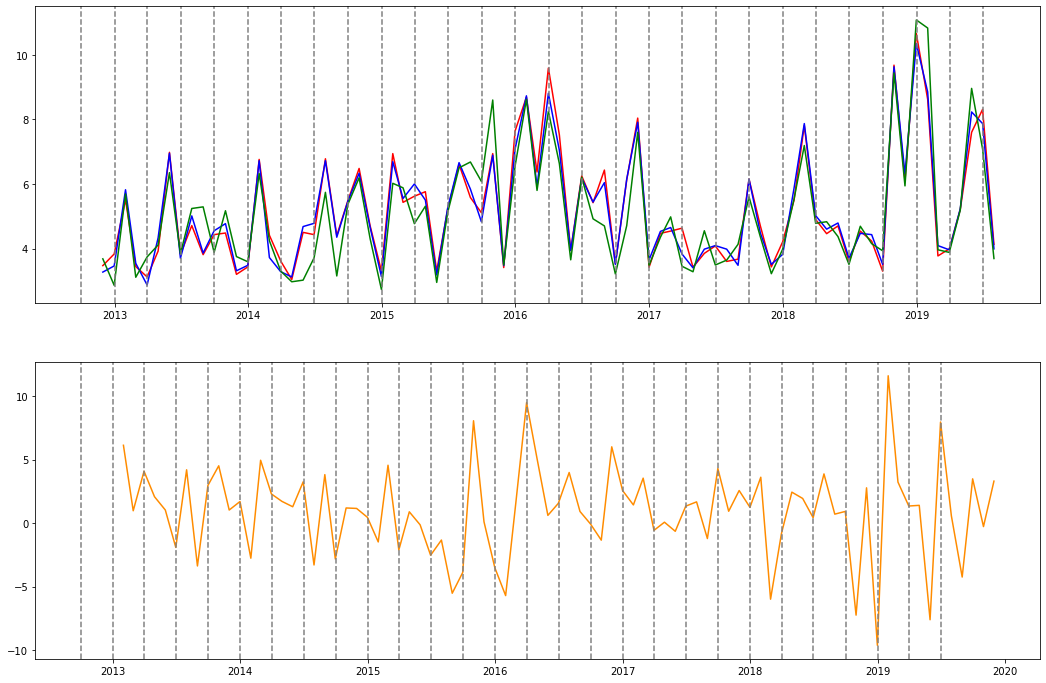

In [329]:
fig, ax = plt.subplots(figsize=(18,12))
plt.subplot(2, 1, 1)
plt.plot(table["Dates"],table["MAE_CB"],color="red",label="CB")#["MAE_RF"].mean()
plt.plot(table["Dates"],table["MAE_RF"],color="blue",label="RF")
plt.plot(table["Dates"],table["MAE_SVR"],color="green", label="SVR")
for i in np.arange(np.datetime64("2012-12-31"), np.datetime64("2019-12-31"), dtype='datetime64[3M]'):
        plt.axvline(i, ls='--',color="grey")
plt.subplot(2, 1, 2)
plt.plot(df["Date"],df["moy"],color="darkorange")
for i in np.arange(np.datetime64("2012-12-31"), np.datetime64("2019-12-31"), dtype='datetime64[3M]'):
        plt.axvline(i, ls='--',color="grey")

Nous observons deux graphiques ci-dessus. Le premier représente l'évolmution de la MAE pour les 3 algorithmes testés par mois à prédire. 
Le deuxième représente les rendements moyens agregés observés pour chaque mois que l'on cherche à modéliser. 
Nous observons que la métrique de la MAE est d'autant plus mauvaise que les rendements varient fort d'un mois à l'autre.

In [331]:
table.mean(axis=0)

MAE_CB     5.194815
MAE_RF     5.170370
MAE_SVR    5.050988
dtype: float64

# Prédiction des rendements.

Nous créons ici une fonction qui nous permettra de sortir une prédiction pour chaque mois, de telle sorte qu'à chaque mois, 3 prédictions seront crées. Une prédiction par modèle (SVR, CatBoost et RandomForest). Chacun de ces modèles sera par la même occasion optimisé tous les 6 mois afin de mettre le plus souvent possible à jour le modèle avec l'apport de nouveaux indicateurs trimestriels. 

In [5]:
import catboost as cgb
def model_tunés(date):
    """
    Le but est ici d'actualiser l'optimisation de notre modèle à chaque fin de semestre 
    (deux session de vie des indicateurs).
    Etant limité en terme de processeur, ce sera un moindre mal d'optimiser notre modèle tous les 6 mois
    """
    # Import des données
    X_train,X_val,y_train,y_val,X_pred,ypred,nom = train_set(date,Train_setF,None,cv=True)

    taille = len(ypred)
    # Reformattage 
    date_réelle = date #+ relativedelta(months=-1)
    print("Modélisation de {}".format(date_réelle))
    pointeur = date_réelle.month
    
    #Cat boost
    if pointeur== 2 or pointeur == 8 :
        def cat_hyp(depth,border_count,l2_leaf_reg):
            params = {"iterations": 800,#800
                        "learning_rate": 0.1,
                        "rsm":0.70,
                        'bagging_temperature': 14.077239620289326,
                        "eval_metric": "MAE",
                        "verbose": False}
            params["depth"] = int(round(depth))
            params["l2_leaf_reg"]=l2_leaf_reg
            params["border_count"]=int(round(border_count))

            cv_dataset = cgb.Pool(data =X_train, label = y_train)

            scores = cgb.cv(cv_dataset,params,fold_count=4)
            return (-1 * np.array(scores['test-MAE-mean'])).max()

        pds = {'depth': (2, 7),'l2_leaf_reg': (1,100),'border_count' : (1,255)}
        optimizer = BayesianOptimization(cat_hyp, pds, random_state=2100)
        optimizer.maximize(init_points=2, n_iter=4)
        Optimum = optimizer.max
        cat_boost = CatBoostRegressor(iterations=2000, learning_rate=0.01,
                                      rsm =0.70,
                                      bagging_temperature = 14.077239620289326,
                                      custom_metric ='MAE',
                                      od_type='Iter',
                                      od_wait=70,eval_metric='MAE',
                                      depth = round(Optimum["params"]["depth"]),
                                      border_count = round(Optimum["params"]["border_count"]),
                                      l2_leaf_reg = Optimum["params"]["l2_leaf_reg"])
        train_pool = Pool(data = X_train, label = y_train)#, cat_features=X["month"]
        cat_boost.fit(train_pool,verbose=False,plot=False)
        cat_boost.save_model("cat_boost.cbm")
    else : 
        cat_boost = CatBoostRegressor()
        cat_boost.load_model("cat_boost.cbm")
    forecast_CB = cat_boost.predict(X_pred)
    errors_CB = abs(forecast_CB - ypred)
    print('Mean Absolute Error CB:', round(np.mean(errors_CB), 2),'%')
    
    # Random Forest 
    if pointeur== 2 or pointeur == 8 :
        rf_param_grid = {'max_depth' : [20,50],'n_estimators': [1000,1200],'min_samples_split': [6,8]}
        rf = RandomForestRegressor(n_jobs=-1)
        rf_tuné = GridSearchCV(param_grid=rf_param_grid, estimator = rf, scoring = "neg_mean_absolute_error", cv = 4)
        rf_tuné.fit(X_train, y_train)
        joblib.dump(rf_tuné, 'RF.pkl') 
    else : 
        rf_tuné = joblib.load('RF.pkl')
    forecast_RF = rf_tuné.predict(X_pred)
    errors_RF = abs(forecast_RF - ypred)# Print out the mean absolute error (mae)
    print('Mean Absolute Error RF:', round(np.mean(errors_RF), 2),'%')
    
    # SVR
    if pointeur== 2 or pointeur == 8 :
        gsc = GridSearchCV(
        estimator=SVR(kernel='rbf'),
        param_grid={
            'C': [0.1, 1, 100],
            'epsilon': [0.001,0.01, 0.1, 0.5, 1, 5],
            'gamma': [0.005, 0.1, 1, 5]
        },
        cv=4, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
        gsc.fit(X_train, y_train)
        joblib.dump(gsc, 'SVR_m.pkl') 
    else : 
        gsc = joblib.load('SVR_m.pkl')
    forecast_SVR = gsc.predict(X_pred)
    errors_SVR = abs(forecast_SVR - ypred)# Print out the mean absolute error (mae)
    print('Mean Absolute Error SVR:', round(np.mean(errors_SVR), 2),'%')

    return date_réelle, errors_CB, errors_RF, errors_SVR,forecast_CB, forecast_RF, forecast_SVR, ypred ,taille,nom #,SF_CB_POS,SF_CB_NEG,SF_RF_POS,SF_RF_NEG

In [6]:
MAE_CB = []
MAE_RF = []
MAE_SVR = []
length=[]
Mois_à_prédire =[]
Prévision_RF = []
Prévision_CB = []
Prévision_SVR = []
Rendements_observés = []
Titres = []

for prévision in pd.to_datetime(np.arange(np.datetime64("2013-03-01"), np.datetime64("2019-10-01"), dtype='datetime64[M]'))- datetime.timedelta(days=1):
    date_réelle, errors_CB, errors_RF, errors_SVR,forecast_CB, forecast_RF, forecast_SVR, ypred ,taille,nom = model_tunés(prévision)
    Mois_à_prédire.append(date_réelle)
    MAE_CB.append(round(np.mean(errors_CB), 2))
    MAE_RF.append(round(np.mean(errors_RF), 2))
    MAE_SVR.append(round(np.mean(errors_SVR), 2))
    Prévision_RF.append(forecast_RF)
    Prévision_CB.append(forecast_CB)
    Prévision_SVR.append(forecast_SVR)
    Rendements_observés.append(ypred)
    length.append(taille)
    Titres.append(nom)
tab_RF = pd.DataFrame(list(zip(Titres[0],Prévision_RF[0],Rendements_observés[0])),columns=["Titres","Rdt_Pred","Rdt_Obs"])
tab_CB = pd.DataFrame(list(zip(Titres[0],Prévision_CB[0],Rendements_observés[0])),columns=["Titres","Rdt_Pred","Rdt_Obs"])
tab_SVR = pd.DataFrame(list(zip(Titres[0],Prévision_SVR[0],Rendements_observés[0])),columns=["Titres","Rdt_Pred","Rdt_Obs"])
for i in np.arange(1,len(Titres)-1,1):
    new_RF = pd.DataFrame(list(zip(Titres[i],Prévision_RF[i],Rendements_observés[i])),columns=["Titres","Rdt_Pred","Rdt_Obs"])
    tab_RF = tab_RF.merge(new_RF,how="outer",left_on="Titres",right_on="Titres",suffixes=('_{}'.format(Mois_à_prédire[i]), '_{}'.format(Mois_à_prédire[i+1])))
    new_CB = pd.DataFrame(list(zip(Titres[i],Prévision_CB[i],Rendements_observés[i])),columns=["Titres","Rdt_Pred","Rdt_Obs"])
    tab_CB = tab_CB.merge(new_CB,how="outer",left_on="Titres",right_on="Titres",suffixes=('_{}'.format(Mois_à_prédire[i]), '_{}'.format(Mois_à_prédire[i+1])))
    new_SVR = pd.DataFrame(list(zip(Titres[i],Prévision_SVR[i],Rendements_observés[i])),columns=["Titres","Rdt_Pred","Rdt_Obs"])
    tab_SVR = tab_SVR.merge(new_SVR,how="outer",left_on="Titres",right_on="Titres",suffixes=('_{}'.format(Mois_à_prédire[i]), '_{}'.format(Mois_à_prédire[i+1])))
Prédiction_Finale = pd.DataFrame(list(zip(Mois_à_prédire,MAE_CB,MAE_RF,MAE_SVR,length)),columns=["Dates",'MAE_CB',"MAE_RF","MAE_SVR","Nb_Titres"])

Nombre de titres à prédire : 39
Modélisation de 2013-02-28 00:00:00
|   iter    |  target   | border... |   depth   | l2_lea... |
-------------------------------------------------------------


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


|  1        | -4.673    |  216.2    |  2.116    |  9.597    |
|  2        | -4.58     |  86.31    |  4.444    |  30.69    |
|  3        | -4.91     |  1.0      |  2.0      |  100.0    |
|  4        | -4.934    |  1.0      |  7.0      |  1.0      |
|  5        | -4.597    |  84.7     |  3.368    |  29.5     |
|  6        | -4.582    |  255.0    |  7.0      |  100.0    |
Mean Absolute Error CB: 3.46 %
Mean Absolute Error RF: 3.53 %
Mean Absolute Error SVR: 3.17 %
Nombre de titres à prédire : 42
Modélisation de 2013-03-31 00:00:00
Mean Absolute Error CB: 3.73 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 3.11 %
Mean Absolute Error SVR: 3.64 %
Nombre de titres à prédire : 42
Modélisation de 2013-04-30 00:00:00
Mean Absolute Error CB: 4.13 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 4.33 %
Mean Absolute Error SVR: 4.11 %
Nombre de titres à prédire : 42
Modélisation de 2013-05-31 00:00:00
Mean Absolute Error CB: 6.68 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 6.94 %
Mean Absolute Error SVR: 6.13 %
Nombre de titres à prédire : 44
Modélisation de 2013-06-30 00:00:00
Mean Absolute Error CB: 3.07 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 3.46 %
Mean Absolute Error SVR: 3.6 %
Nombre de titres à prédire : 44
Modélisation de 2013-07-31 00:00:00
Mean Absolute Error CB: 4.61 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 5.04 %
Mean Absolute Error SVR: 5.22 %
Nombre de titres à prédire : 44
Modélisation de 2013-08-31 00:00:00
|   iter    |  target   | border... |   depth   | l2_lea... |
-------------------------------------------------------------


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


|  1        | -4.638    |  216.2    |  2.116    |  9.597    |
|  2        | -4.598    |  86.31    |  4.444    |  30.69    |
|  3        | -4.642    |  3.417    |  2.596    |  99.58    |
|  4        | -4.931    |  1.0      |  2.0      |  1.0      |
|  5        | -4.575    |  83.6     |  5.324    |  30.23    |
|  6        | -4.593    |  255.0    |  7.0      |  100.0    |
Mean Absolute Error CB: 3.81 %
Mean Absolute Error RF: 3.84 %
Mean Absolute Error SVR: 5.3 %
Nombre de titres à prédire : 45
Modélisation de 2013-09-30 00:00:00
Mean Absolute Error CB: 4.29 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 4.43 %
Mean Absolute Error SVR: 3.77 %
Nombre de titres à prédire : 45
Modélisation de 2013-10-31 00:00:00
Mean Absolute Error CB: 4.39 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 4.79 %
Mean Absolute Error SVR: 5.14 %
Nombre de titres à prédire : 45
Modélisation de 2013-11-30 00:00:00
Mean Absolute Error CB: 3.4 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 3.32 %
Mean Absolute Error SVR: 3.69 %
Nombre de titres à prédire : 45
Modélisation de 2013-12-31 00:00:00
Mean Absolute Error CB: 3.66 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 3.47 %
Mean Absolute Error SVR: 3.56 %
Nombre de titres à prédire : 45
Modélisation de 2014-01-31 00:00:00
Mean Absolute Error CB: 7.67 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 6.59 %
Mean Absolute Error SVR: 6.39 %
Nombre de titres à prédire : 45
Modélisation de 2014-02-28 00:00:00
|   iter    |  target   | border... |   depth   | l2_lea... |
-------------------------------------------------------------


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


|  1        | -4.674    |  216.2    |  2.116    |  9.597    |
|  2        | -4.615    |  86.31    |  4.444    |  30.69    |
|  3        | -4.947    |  1.0      |  2.0      |  100.0    |
|  4        | -4.938    |  1.0      |  7.0      |  1.0      |
|  5        | -4.618    |  84.7     |  3.368    |  29.5     |
|  6        | -4.645    |  252.5    |  5.115    |  99.69    |
Mean Absolute Error CB: 4.03 %
Mean Absolute Error RF: 3.75 %
Mean Absolute Error SVR: 4.2 %
Nombre de titres à prédire : 45
Modélisation de 2014-03-31 00:00:00
Mean Absolute Error CB: 3.59 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 3.49 %
Mean Absolute Error SVR: 3.31 %
Nombre de titres à prédire : 45
Modélisation de 2014-04-30 00:00:00
Mean Absolute Error CB: 2.93 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 3.14 %
Mean Absolute Error SVR: 3.0 %
Nombre de titres à prédire : 45
Modélisation de 2014-05-31 00:00:00
Mean Absolute Error CB: 4.01 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 4.71 %
Mean Absolute Error SVR: 2.99 %
Nombre de titres à prédire : 47
Modélisation de 2014-06-30 00:00:00
Mean Absolute Error CB: 4.45 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 4.83 %
Mean Absolute Error SVR: 3.76 %
Nombre de titres à prédire : 47
Modélisation de 2014-07-31 00:00:00
Mean Absolute Error CB: 6.18 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 6.84 %
Mean Absolute Error SVR: 5.57 %
Nombre de titres à prédire : 47
Modélisation de 2014-08-31 00:00:00
|   iter    |  target   | border... |   depth   | l2_lea... |
-------------------------------------------------------------


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


|  1        | -4.654    |  216.2    |  2.116    |  9.597    |
|  2        | -4.563    |  86.31    |  4.444    |  30.69    |
|  3        | -4.851    |  1.0      |  2.0      |  100.0    |
|  4        | -4.848    |  1.0      |  7.0      |  1.0      |
|  5        | -4.581    |  84.7     |  3.368    |  29.5     |
|  6        | -4.56     |  255.0    |  7.0      |  100.0    |
Mean Absolute Error CB: 4.21 %
Mean Absolute Error RF: 4.38 %
Mean Absolute Error SVR: 3.15 %
Nombre de titres à prédire : 47
Modélisation de 2014-09-30 00:00:00
Mean Absolute Error CB: 4.94 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 5.27 %
Mean Absolute Error SVR: 5.26 %
Nombre de titres à prédire : 47
Modélisation de 2014-10-31 00:00:00
Mean Absolute Error CB: 6.12 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 6.35 %
Mean Absolute Error SVR: 6.25 %
Nombre de titres à prédire : 47
Modélisation de 2014-11-30 00:00:00
Mean Absolute Error CB: 4.39 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 4.53 %
Mean Absolute Error SVR: 4.4 %
Nombre de titres à prédire : 47
Modélisation de 2014-12-31 00:00:00
Mean Absolute Error CB: 2.82 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 2.98 %
Mean Absolute Error SVR: 2.75 %
Nombre de titres à prédire : 47
Modélisation de 2015-01-31 00:00:00
Mean Absolute Error CB: 6.43 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 6.66 %
Mean Absolute Error SVR: 6.08 %
Nombre de titres à prédire : 47
Modélisation de 2015-02-28 00:00:00


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


|   iter    |  target   | border... |   depth   | l2_lea... |
-------------------------------------------------------------
|  1        | -4.678    |  216.2    |  2.116    |  9.597    |
|  2        | -4.575    |  86.31    |  4.444    |  30.69    |
|  3        | -4.844    |  1.0      |  2.0      |  100.0    |
|  4        | -4.845    |  1.0      |  7.0      |  1.0      |
|  5        | -4.581    |  83.6     |  5.324    |  30.23    |
|  6        | -4.611    |  252.5    |  5.115    |  99.69    |
Mean Absolute Error CB: 5.62 %
Mean Absolute Error RF: 5.58 %
Mean Absolute Error SVR: 5.97 %
Nombre de titres à prédire : 47
Modélisation de 2015-03-31 00:00:00
Mean Absolute Error CB: 5.55 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 5.61 %
Mean Absolute Error SVR: 4.68 %
Nombre de titres à prédire : 47
Modélisation de 2015-04-30 00:00:00
Mean Absolute Error CB: 5.38 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 5.46 %
Mean Absolute Error SVR: 5.29 %
Nombre de titres à prédire : 47
Modélisation de 2015-05-31 00:00:00
Mean Absolute Error CB: 3.27 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 2.97 %
Mean Absolute Error SVR: 2.96 %
Nombre de titres à prédire : 47
Modélisation de 2015-06-30 00:00:00
Mean Absolute Error CB: 4.95 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 5.17 %
Mean Absolute Error SVR: 5.0 %
Nombre de titres à prédire : 47
Modélisation de 2015-07-31 00:00:00
Mean Absolute Error CB: 6.52 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 6.56 %
Mean Absolute Error SVR: 6.57 %
Nombre de titres à prédire : 47
Modélisation de 2015-08-31 00:00:00
|   iter    |  target   | border... |   depth   | l2_lea... |
-------------------------------------------------------------


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


|  1        | -4.694    |  216.2    |  2.116    |  9.597    |
|  2        | -4.611    |  86.31    |  4.444    |  30.69    |
|  3        | -4.877    |  1.0      |  2.0      |  100.0    |
|  4        | -4.851    |  1.0      |  7.0      |  1.0      |
|  5        | -4.6      |  83.6     |  5.324    |  30.23    |
|  6        | -4.642    |  255.0    |  7.0      |  100.0    |
Mean Absolute Error CB: 5.16 %
Mean Absolute Error RF: 5.63 %
Mean Absolute Error SVR: 6.5 %
Nombre de titres à prédire : 47
Modélisation de 2015-09-30 00:00:00
Mean Absolute Error CB: 4.97 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 5.04 %
Mean Absolute Error SVR: 6.1 %
Nombre de titres à prédire : 47
Modélisation de 2015-10-31 00:00:00
Mean Absolute Error CB: 6.84 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 6.77 %
Mean Absolute Error SVR: 8.52 %
Nombre de titres à prédire : 47
Modélisation de 2015-11-30 00:00:00
Mean Absolute Error CB: 3.49 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 3.59 %
Mean Absolute Error SVR: 3.41 %
Nombre de titres à prédire : 47
Modélisation de 2015-12-31 00:00:00
Mean Absolute Error CB: 6.82 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 6.72 %
Mean Absolute Error SVR: 6.39 %
Nombre de titres à prédire : 47
Modélisation de 2016-01-31 00:00:00
Mean Absolute Error CB: 9.34 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 8.94 %
Mean Absolute Error SVR: 8.62 %
Nombre de titres à prédire : 47
Modélisation de 2016-02-29 00:00:00
|   iter    |  target   | border... |   depth   | l2_lea... |
-------------------------------------------------------------


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


|  1        | -4.849    |  216.2    |  2.116    |  9.597    |
|  2        | -4.751    |  86.31    |  4.444    |  30.69    |
|  3        | -4.995    |  1.0      |  2.0      |  100.0    |
|  4        | -4.967    |  1.0      |  7.0      |  1.0      |
|  5        | -4.751    |  83.6     |  5.324    |  30.23    |
|  6        | -4.733    |  253.1    |  6.139    |  98.99    |
Mean Absolute Error CB: 5.61 %
Mean Absolute Error RF: 5.77 %
Mean Absolute Error SVR: 5.72 %
Nombre de titres à prédire : 47
Modélisation de 2016-03-31 00:00:00
Mean Absolute Error CB: 8.47 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 8.47 %
Mean Absolute Error SVR: 8.31 %
Nombre de titres à prédire : 47
Modélisation de 2016-04-30 00:00:00
Mean Absolute Error CB: 6.77 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 7.03 %
Mean Absolute Error SVR: 6.61 %
Nombre de titres à prédire : 47
Modélisation de 2016-05-31 00:00:00
Mean Absolute Error CB: 3.47 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 3.92 %
Mean Absolute Error SVR: 3.67 %
Nombre de titres à prédire : 47
Modélisation de 2016-06-30 00:00:00
Mean Absolute Error CB: 6.32 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 6.09 %
Mean Absolute Error SVR: 6.21 %
Nombre de titres à prédire : 47
Modélisation de 2016-07-31 00:00:00
Mean Absolute Error CB: 5.06 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 5.4 %
Mean Absolute Error SVR: 5.06 %
Nombre de titres à prédire : 47
Modélisation de 2016-08-31 00:00:00
|   iter    |  target   | border... |   depth   | l2_lea... |
-------------------------------------------------------------


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


|  1        | -4.942    |  216.2    |  2.116    |  9.597    |
|  2        | -4.812    |  86.31    |  4.444    |  30.69    |
|  3        | -5.055    |  1.0      |  2.0      |  100.0    |
|  4        | -5.001    |  1.0      |  7.0      |  1.0      |
|  5        | -4.782    |  83.6     |  5.324    |  30.23    |
|  6        | -4.794    |  255.0    |  7.0      |  100.0    |
Mean Absolute Error CB: 5.63 %
Mean Absolute Error RF: 5.77 %
Mean Absolute Error SVR: 4.72 %
Nombre de titres à prédire : 48
Modélisation de 2016-09-30 00:00:00
Mean Absolute Error CB: 3.16 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 3.39 %
Mean Absolute Error SVR: 2.95 %
Nombre de titres à prédire : 48
Modélisation de 2016-10-31 00:00:00
Mean Absolute Error CB: 6.12 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 5.79 %
Mean Absolute Error SVR: 4.76 %
Nombre de titres à prédire : 48
Modélisation de 2016-11-30 00:00:00
Mean Absolute Error CB: 8.08 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 8.06 %
Mean Absolute Error SVR: 7.72 %
Nombre de titres à prédire : 48
Modélisation de 2016-12-31 00:00:00
Mean Absolute Error CB: 3.57 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 3.78 %
Mean Absolute Error SVR: 3.58 %
Nombre de titres à prédire : 48
Modélisation de 2017-01-31 00:00:00
Mean Absolute Error CB: 4.58 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 4.32 %
Mean Absolute Error SVR: 4.25 %
Nombre de titres à prédire : 48
Modélisation de 2017-02-28 00:00:00
|   iter    |  target   | border... |   depth   | l2_lea... |
-------------------------------------------------------------


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


|  1        | -4.976    |  216.2    |  2.116    |  9.597    |
|  2        | -4.857    |  86.31    |  4.444    |  30.69    |
|  3        | -5.068    |  1.0      |  2.0      |  100.0    |
|  4        | -5.056    |  1.0      |  7.0      |  1.0      |
|  5        | -4.831    |  83.6     |  5.324    |  30.23    |
|  6        | -4.828    |  255.0    |  7.0      |  100.0    |
Mean Absolute Error CB: 4.75 %
Mean Absolute Error RF: 4.63 %
Mean Absolute Error SVR: 5.19 %
Nombre de titres à prédire : 48
Modélisation de 2017-03-31 00:00:00
Mean Absolute Error CB: 3.72 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 3.98 %
Mean Absolute Error SVR: 3.13 %
Nombre de titres à prédire : 48
Modélisation de 2017-04-30 00:00:00
Mean Absolute Error CB: 3.27 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 3.38 %
Mean Absolute Error SVR: 3.21 %
Nombre de titres à prédire : 48
Modélisation de 2017-05-31 00:00:00
Mean Absolute Error CB: 4.32 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 4.09 %
Mean Absolute Error SVR: 4.43 %
Nombre de titres à prédire : 48
Modélisation de 2017-06-30 00:00:00
Mean Absolute Error CB: 3.7 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 3.75 %
Mean Absolute Error SVR: 3.61 %
Nombre de titres à prédire : 48
Modélisation de 2017-07-31 00:00:00
Mean Absolute Error CB: 3.48 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 3.95 %
Mean Absolute Error SVR: 3.57 %
Nombre de titres à prédire : 48
Modélisation de 2017-08-31 00:00:00
|   iter    |  target   | border... |   depth   | l2_lea... |
-------------------------------------------------------------


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


|  1        | -4.887    |  216.2    |  2.116    |  9.597    |
|  2        | -4.769    |  86.31    |  4.444    |  30.69    |
|  3        | -4.985    |  1.0      |  2.0      |  100.0    |
|  4        | -4.969    |  1.0      |  7.0      |  1.0      |
|  5        | -4.747    |  83.6     |  5.324    |  30.23    |
|  6        | -4.753    |  255.0    |  7.0      |  100.0    |
Mean Absolute Error CB: 3.65 %
Mean Absolute Error RF: 3.51 %
Mean Absolute Error SVR: 4.02 %
Nombre de titres à prédire : 48
Modélisation de 2017-09-30 00:00:00
Mean Absolute Error CB: 6.39 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 6.05 %
Mean Absolute Error SVR: 5.44 %
Nombre de titres à prédire : 48
Modélisation de 2017-10-31 00:00:00
Mean Absolute Error CB: 4.6 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 4.51 %
Mean Absolute Error SVR: 4.32 %
Nombre de titres à prédire : 48
Modélisation de 2017-11-30 00:00:00
Mean Absolute Error CB: 3.27 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 3.23 %
Mean Absolute Error SVR: 3.25 %
Nombre de titres à prédire : 48
Modélisation de 2017-12-31 00:00:00
Mean Absolute Error CB: 3.74 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 3.67 %
Mean Absolute Error SVR: 3.95 %
Nombre de titres à prédire : 48
Modélisation de 2018-01-31 00:00:00
Mean Absolute Error CB: 5.62 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 5.91 %
Mean Absolute Error SVR: 5.66 %
Nombre de titres à prédire : 48
Modélisation de 2018-02-28 00:00:00
|   iter    |  target   | border... |   depth   | l2_lea... |
-------------------------------------------------------------


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


|  1        | -4.876    |  216.2    |  2.116    |  9.597    |
|  2        | -4.785    |  86.31    |  4.444    |  30.69    |
|  3        | -4.954    |  1.0      |  2.0      |  100.0    |
|  4        | -4.944    |  1.0      |  7.0      |  1.0      |
|  5        | -4.778    |  83.6     |  5.324    |  30.23    |
|  6        | -4.753    |  255.0    |  7.0      |  100.0    |
Mean Absolute Error CB: 7.73 %
Mean Absolute Error RF: 7.83 %
Mean Absolute Error SVR: 7.07 %
Nombre de titres à prédire : 48
Modélisation de 2018-03-31 00:00:00
Mean Absolute Error CB: 5.03 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 5.19 %
Mean Absolute Error SVR: 4.77 %
Nombre de titres à prédire : 48
Modélisation de 2018-04-30 00:00:00
Mean Absolute Error CB: 4.59 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 4.56 %
Mean Absolute Error SVR: 4.78 %
Nombre de titres à prédire : 48
Modélisation de 2018-05-31 00:00:00
Mean Absolute Error CB: 4.48 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 4.86 %
Mean Absolute Error SVR: 4.36 %
Nombre de titres à prédire : 48
Modélisation de 2018-06-30 00:00:00
Mean Absolute Error CB: 3.35 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 3.7 %
Mean Absolute Error SVR: 3.51 %
Nombre de titres à prédire : 48
Modélisation de 2018-07-31 00:00:00
Mean Absolute Error CB: 4.3 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 4.5 %
Mean Absolute Error SVR: 4.61 %
Nombre de titres à prédire : 48
Modélisation de 2018-08-31 00:00:00
|   iter    |  target   | border... |   depth   | l2_lea... |
-------------------------------------------------------------


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


|  1        | -4.874    |  216.2    |  2.116    |  9.597    |
|  2        | -4.785    |  86.31    |  4.444    |  30.69    |
|  3        | -4.937    |  1.0      |  2.0      |  100.0    |
|  4        | -4.94     |  1.0      |  7.0      |  1.0      |
|  5        | -4.749    |  83.6     |  5.324    |  30.23    |
|  6        | -4.756    |  255.0    |  7.0      |  100.0    |
Mean Absolute Error CB: 4.06 %
Mean Absolute Error RF: 4.32 %
Mean Absolute Error SVR: 4.18 %
Nombre de titres à prédire : 48
Modélisation de 2018-09-30 00:00:00
Mean Absolute Error CB: 3.45 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 3.59 %
Mean Absolute Error SVR: 3.99 %
Nombre de titres à prédire : 48
Modélisation de 2018-10-31 00:00:00
Mean Absolute Error CB: 10.02 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 9.51 %
Mean Absolute Error SVR: 9.31 %
Nombre de titres à prédire : 48
Modélisation de 2018-11-30 00:00:00
Mean Absolute Error CB: 5.71 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 6.04 %
Mean Absolute Error SVR: 6.01 %
Nombre de titres à prédire : 49
Modélisation de 2018-12-31 00:00:00
Mean Absolute Error CB: 10.89 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 10.94 %
Mean Absolute Error SVR: 10.89 %
Nombre de titres à prédire : 47
Modélisation de 2019-01-31 00:00:00
Mean Absolute Error CB: 9.79 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 8.96 %
Mean Absolute Error SVR: 10.82 %
Nombre de titres à prédire : 47
Modélisation de 2019-02-28 00:00:00
|   iter    |  target   | border... |   depth   | l2_lea... |
-------------------------------------------------------------


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


|  1        | -5.006    |  216.2    |  2.116    |  9.597    |
|  2        | -4.915    |  86.31    |  4.444    |  30.69    |
|  3        | -5.149    |  1.0      |  2.0      |  100.0    |
|  4        | -5.132    |  1.0      |  7.0      |  1.0      |
|  5        | -4.885    |  83.6     |  5.324    |  30.23    |
|  6        | -4.888    |  255.0    |  7.0      |  100.0    |
Mean Absolute Error CB: 3.97 %
Mean Absolute Error RF: 3.91 %
Mean Absolute Error SVR: 3.92 %
Nombre de titres à prédire : 47
Modélisation de 2019-03-31 00:00:00
Mean Absolute Error CB: 3.65 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 3.93 %
Mean Absolute Error SVR: 4.01 %
Nombre de titres à prédire : 47
Modélisation de 2019-04-30 00:00:00
Mean Absolute Error CB: 5.09 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 5.19 %
Mean Absolute Error SVR: 5.32 %
Nombre de titres à prédire : 47
Modélisation de 2019-05-31 00:00:00
Mean Absolute Error CB: 8.06 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 8.07 %
Mean Absolute Error SVR: 8.7 %
Nombre de titres à prédire : 47
Modélisation de 2019-06-30 00:00:00
Mean Absolute Error CB: 7.73 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 7.54 %
Mean Absolute Error SVR: 7.24 %
Nombre de titres à prédire : 44
Modélisation de 2019-07-31 00:00:00
Mean Absolute Error CB: 3.72 %


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mean Absolute Error RF: 3.93 %
Mean Absolute Error SVR: 3.68 %
Nombre de titres à prédire : 44
Modélisation de 2019-08-31 00:00:00
|   iter    |  target   | border... |   depth   | l2_lea... |
-------------------------------------------------------------


C:\Users\louis\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


|  1        | -5.038    |  216.2    |  2.116    |  9.597    |
|  2        | -4.947    |  86.31    |  4.444    |  30.69    |
|  3        | -5.166    |  1.0      |  2.0      |  100.0    |
|  4        | -5.159    |  1.0      |  7.0      |  1.0      |
|  5        | -4.926    |  83.6     |  5.324    |  30.23    |
|  6        | -4.914    |  255.0    |  7.0      |  100.0    |
Mean Absolute Error CB: 7.16 %
Mean Absolute Error RF: 6.72 %
Mean Absolute Error SVR: 7.94 %


On peut voir ci-dessus que l'optimisation de l'algorithme de Catboost nous permet de diminuer un petit peu nos erreurs. Cette optimisation est donc importante.

Le code nous permet de générer 3 tables de rendements prédits: une table pour les prédictions liées au SVR, une autre pour le Random FOrest et enfin une autre pour le Catboost.

In [7]:
#Prédiction_Finale.to_csv("Prédiction_Finale.csv",index=False)
#tab_RF.to_csv("Prédictions_RF.csv",index=False)
#tab_CB.to_csv("Prédictions_CB.csv",index=False)
#tab_SVR.to_csv("Prédictions_SVR.csv", index=False)

In [5]:
table_CB = pd.read_csv("Prédictions_CB.csv").set_index("Titres").iloc[:,0:84]
table_RF = pd.read_csv("Prédictions_RF.csv").set_index("Titres").iloc[:,0:84]
table_SVR = pd.read_csv("Prédictions_SVR.csv").set_index("Titres").iloc[:,0:84]

In [6]:
def Opti_Signaux_forts_faibles(table):
    Nombre_Titre_Pos_Pred = []
    Seuil_pos = []
    Moyenne_obs_pos = []
    Nombre_Titre_Neg_Pred = []
    Seuil_neg = []
    Moyenne_obs_neg = []
    for i in np.arange(0,table.shape[1],2):
        temp = table.iloc[:,i:i+2]
        for threshold_pos in np.arange(0,5,0.01):
            prevision_pos = temp[temp.iloc[:,0] > threshold_pos].iloc[:,1].mean()
            NB_Pos = len(temp[temp.iloc[:,0] > threshold_pos])
            Seuil_pos.append(round(threshold_pos,2))
            Moyenne_obs_pos.append(prevision_pos)
            Nombre_Titre_Pos_Pred.append(NB_Pos)
        for threshold_neg in np.arange(-5,0,0.01):
            prevision_neg = temp[temp.iloc[:,0] < threshold_neg].iloc[:,1].mean()
            NB_Neg = len(temp[temp.iloc[:,0] < threshold_neg])
            Seuil_neg.append(round(threshold_neg,2))
            Moyenne_obs_neg.append(prevision_neg)
            Nombre_Titre_Neg_Pred.append(NB_Neg)
    Résultat = pd.DataFrame(list(zip(Seuil_pos,Nombre_Titre_Pos_Pred,Moyenne_obs_pos,Seuil_neg,Nombre_Titre_Neg_Pred,Moyenne_obs_neg)),columns=["Seuil_pos","Nombre_Titre_Pos_Pred","Moyenne_obs_pos","Seuil_neg","Nombre_Titre_Neg_Pred","Moyenne_obs_neg"])
    Résultat_pos = Résultat.groupby("Seuil_pos")["Moyenne_obs_pos"].mean().reset_index()
    Résultat_neg = Résultat.groupby("Seuil_neg")["Moyenne_obs_neg"].mean().reset_index()
    print("Sur la période étudiée, pour un seuil optimal de {}, nous observons des rendements moyens de {}%".format(Résultat_pos.loc[Résultat_pos.Moyenne_obs_pos.idxmax(),:][0],round(Résultat_pos.loc[Résultat_pos.Moyenne_obs_pos.idxmax(),:][1],1)))
    #print("Sur la période étudiée, pour un seuil optimal de {}, nous observons des rendements moyens de {}%".format(Résultat_neg.loc[Résultat_neg.Moyenne_obs_neg.idxmin(),:][0],round(Résultat_neg.loc[Résultat_neg.Moyenne_obs_neg.idxmin(),:][1],1)))
    
    data = Résultat#.fillna(0)
    data_pos=data[["Seuil_pos","Nombre_Titre_Pos_Pred","Moyenne_obs_pos"]]
    data_pos = data_pos.groupby("Seuil_pos")["Nombre_Titre_Pos_Pred","Moyenne_obs_pos"].mean().reset_index()
    data_neg=data[["Seuil_neg","Nombre_Titre_Neg_Pred","Moyenne_obs_neg"]]
    data_neg = data_neg.groupby("Seuil_neg")["Nombre_Titre_Neg_Pred","Moyenne_obs_neg"].mean().reset_index()
    fig, ax0 = plt.subplots(figsize=(18,12))
    ax0 = plt.subplot(211)
    ax0.plot(data_pos["Seuil_pos"],data_pos["Moyenne_obs_pos"] , '-', label = 'Moyenne des rendements')
    ax1 = ax0.twinx()
    ax1.plot(data_pos["Seuil_pos"],data_pos["Nombre_Titre_Pos_Pred"] , '-r', label = 'Nombre de titres')
    ax0.legend(loc=0)
    ax1.legend(loc=0)
    ax0.grid()
    ax0.set_xlabel("Seuil de signe fort positif")
    ax0.set_ylabel("Moyenne des Rendements Observés Positifs")
    ax1.set_ylabel("Nombre de Titre")
    ax2 = plt.subplot(212)
    ax2.plot(data_neg["Seuil_neg"],data_neg["Moyenne_obs_neg"] , '-', label = 'Moyenne des rendements')
    ax2.grid()
    ax3 = ax2.twinx()
    ax3.plot(data_neg["Seuil_neg"],data_neg["Nombre_Titre_Neg_Pred"] , '-r', label = 'Nombre de titres')
    ax2.legend(loc=0)
    ax3.legend(loc=0)
    ax2.set_xlabel("Seuil de signe fort négatif")
    ax2.set_ylabel("Moyenne des Rendements Observés Négatif")
    ax3.set_ylabel("Nombre de Titre")
    plt.show()
    
    return Résultat

Sur la période étudiée, pour un seuil optimal de 4.01, nous observons des rendements moyens de 2.6%


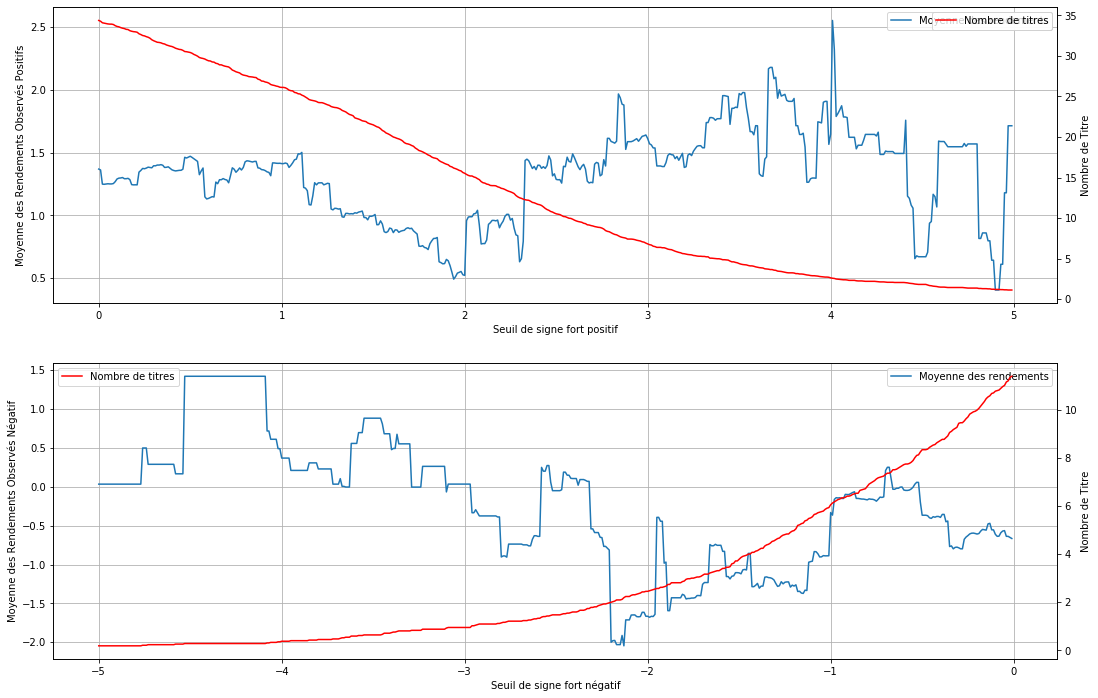

In [7]:
data1 = Opti_Signaux_forts_faibles(table_CB)

# A la vue du graphique, nous ne prendrons pas les valuers optimales.
#Les valeurs optimales ne nous laisseront pas assez de titres. 
# Nous décidons donc de prendre un seuil de 2.8 pour le positif et de -1.2 pour le négatif.

Sur la période étudiée, pour un seuil optimal de 2.94, nous observons des rendements moyens de 2.3%


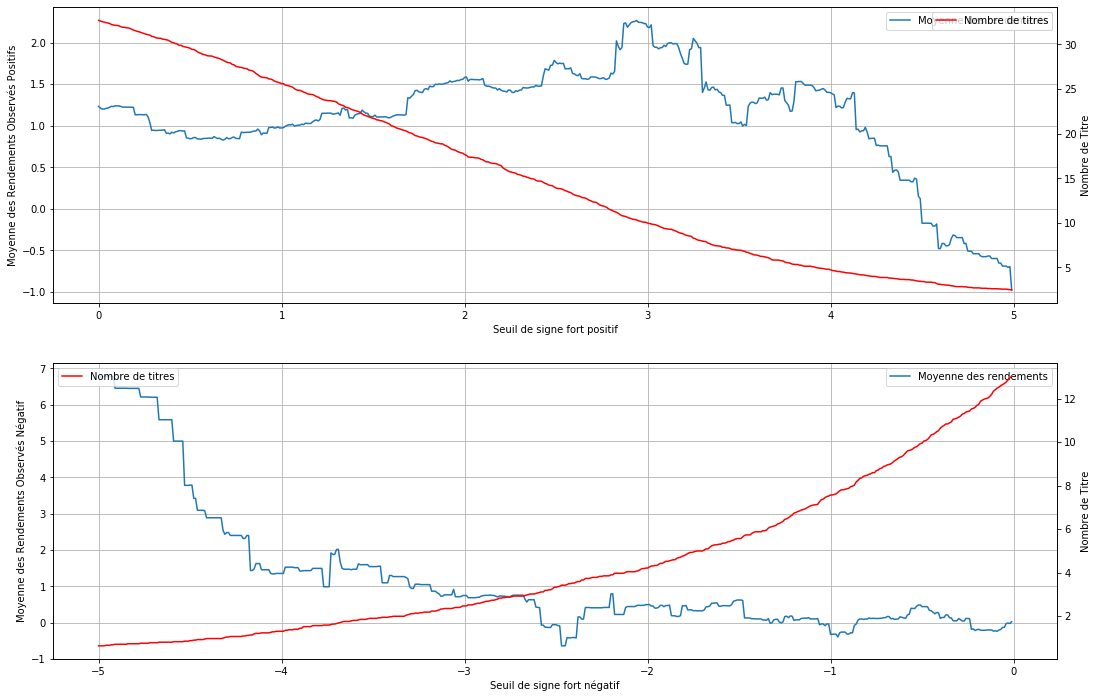

In [8]:
data2 = Opti_Signaux_forts_faibles(table_RF)
# Ici nous gardons les mêmes seuils car nous disposons d'assez d'actif.

Sur la période étudiée, pour un seuil optimal de 1.43, nous observons des rendements moyens de 4.9%


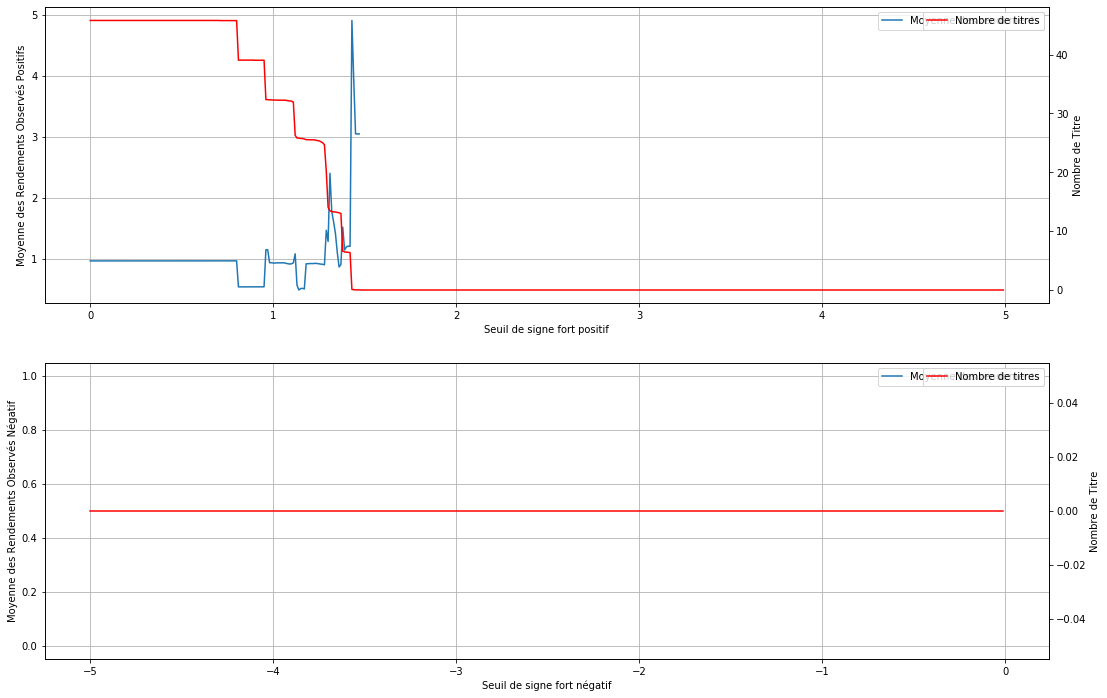

In [9]:
data3 = Opti_Signaux_forts_faibles(table_SVR)

In [10]:
table_CB_pred = pd.read_csv("Prédictions_CB.csv").set_index("Titres")#.iloc[:,84:]
table_RF_pred = pd.read_csv("Prédictions_RF.csv").set_index("Titres")#.iloc[:,84:]
table_SVR_pred = pd.read_csv("Prédictions_SVR.csv").set_index("Titres")#.iloc[:,84:]

In [433]:
def Résultats(table,threshold_pos,threshold_neg):
    PREV_pos = []
    PREV_neg = []
    NOMBRE_Pos =[]
    NOMBRE_Neg =[]
    Titres_Pos  = []
    Titres_Neg = []
    for i in np.arange(0,table.shape[1],2):
        temp = table.iloc[:,i:i+2]
        prevision_pos = temp[temp.iloc[:,0] > threshold_pos].iloc[:,1].mean()
        NB_Pos = len(temp[temp.iloc[:,0] > threshold_pos])
        liste_titres_pos = temp[temp.iloc[:,0] > threshold_pos].index
        if np.isnan(prevision_pos):
            prevision_pos = temp[temp.iloc[:,0] > 2.5].iloc[:,1].mean()
            NB_Pos = len(temp[temp.iloc[:,0] > 2.5])
            liste_titres_pos = temp[temp.iloc[:,0] > threshold_pos].index
            #print("Sur la période étudiée, pour le seuil optimal déterminé précédemment de {}, nous observons des rendements moyens de {}% pour {} titres.".format(2,prevision_pos,NB_Pos))
        #else : 
            #prevision_pos = temp[temp.iloc[:,0] > threshold_pos].iloc[:,1].mean()
            #NB_Pos = len(temp[temp.iloc[:,0] > threshold_pos])
            #print("Sur la période étudiée, pour le seuil optimal déterminé précédemment de {}, nous observons des rendements moyens de {}% pour {} titres.".format(threshold_pos,prevision_pos,NB_Pos))
        
        prevision_neg = temp[temp.iloc[:,0] < threshold_neg].iloc[:,1].mean()
        NB_Neg = len(temp[temp.iloc[:,0] < threshold_neg])
        liste_titres_neg = temp[temp.iloc[:,0] < threshold_neg].index
        if np.isnan(prevision_neg):
            prevision_neg = temp[temp.iloc[:,0] < -0.2].iloc[:,1].mean()
            NB_Neg = len(temp[temp.iloc[:,0] < -0.2])
            liste_titres_neg = temp[temp.iloc[:,0] < threshold_neg].index
            #print("Sur la période étudiée, pour le seuil optimal déterminé précédemment de {}, nous observons des rendements moyens de {}% pour {} titres.".format(-2,prevision_neg,NB_Neg))
        #else : 
            #prevision_neg = temp[temp.iloc[:,0] > threshold_neg].iloc[:,1].mean()
            #NB_Neg = len(temp[temp.iloc[:,0] > threshold_neg])
            #print("Sur la période étudiée, pour le seuil optimal déterminé précédemment de {}, nous observons des rendements moyens de {}% pour {} titres.".format(threshold_neg,prevision_neg,NB_Neg))
        
        PREV_pos.append(prevision_pos)
        NOMBRE_Pos.append(NB_Pos)
        PREV_neg.append(prevision_neg)
        NOMBRE_Neg.append(NB_Neg)
        
    return PREV_pos,NOMBRE_Pos,PREV_neg,NOMBRE_Neg,Titres_Pos,Titres_Neg

In [434]:
PREV_pos_CB,NOMBRE_Pos_CB,PREV_neg_CB,NOMBRE_Neg_CB,Titres_Pos_CB,Titres_Neg_CB = Résultats(table_CB_pred,2.8,-1.2)

In [435]:
PREV_pos_RF,NOMBRE_Pos_RF,PREV_neg_RF,NOMBRE_Neg_RF,Titres_Pos_RF,Titres_Neg_RF = Résultats(table_RF_pred,2.94,-2.47)

In [26]:
#PREV_pos_SVR,NOMBRE_Pos_SVR,PREV_neg_SVR,NOMBRE_Neg_SVR,Titres_Pos_SVR,Titres_Neg_SVR = Résultats(table_SVR_pred,1.5,-1.7)

In [436]:
a = pd.DataFrame(list(zip(PREV_pos_CB,NOMBRE_Pos_CB,PREV_neg_CB,NOMBRE_Neg_CB)),columns=["Rendements_Pred_Pos","Nb_Titres_Pos","Rendements_Pred_Neg","Nb_Titres_Neg"])
a

,Rendements_Pred_Pos,Nb_Titres_Pos,Rendements_Pred_Neg,Nb_Titres_Neg
0,-2.545929,5,NaN,0
1,7.894833,2,2.357944,3
2,2.575226,2,10.588230,1
3,NaN,0,0.933980,37
4,NaN,0,-2.781521,13
...,...,...,...,...
73,7.889195,5,-5.156326,3
74,4.535448,11,20.899770,1
75,-0.796236,1,-11.391866,11
76,14.214015,2,8.566136,8


In [437]:
b = pd.DataFrame(list(zip(PREV_pos_RF,NOMBRE_Pos_RF,PREV_neg_RF,NOMBRE_Neg_RF)),columns=["Rendements_Pred_Pos","Nb_Titres_Pos","Rendements_Pred_Neg","Nb_Titres_Neg"])
b

,Rendements_Pred_Pos,Nb_Titres_Pos,Rendements_Pred_Neg,Nb_Titres_Neg
0,0.917505,18,-6.215084,1
1,5.832592,3,4.715974,1
2,2.744361,12,1.712984,3
3,NaN,0,0.630467,30
4,3.595166,1,0.158027,3
...,...,...,...,...
73,6.204665,4,-4.425695,5
74,5.744740,12,0.274773,7
75,-5.996516,3,-11.524196,7
76,9.114134,4,7.860638,2


In [438]:
table1 = pd.read_csv("Prédictions_CB.csv").set_index("Titres")#.iloc[:,84:]
table2 = pd.read_csv("Prédictions_RF.csv").set_index("Titres")#.iloc[:,84:]

In [440]:
def Portofolio(table, date, méthode, seuil_pos, seuil_neg):
    liste_pred = [x for x in list(table.columns) if "pred" in x.lower()]
    liste_obs = [x for x in list(table.columns) if "obs" in x.lower()]
    table_pred = table[liste_pred]
    table_obs = table[liste_obs]
    table_pred.columns = table_pred.columns.astype(str).str[9:]
    table_obs.columns = table_obs.columns.astype(str).str[8:]
    pre_Table_ptf_création = table_pred
    seuil_pos_bis = sorted(pre_Table_ptf_création[date].dropna())
    seuil_pos_bis = seuil_pos_bis[-int(round(len(seuil_pos_bis)*0.2))]
    rustine = sorted(pre_Table_ptf_création[date].dropna())
    rustine = rustine[-3]
    if méthode == "Long_Only":
        Table_ptf_création = pre_Table_ptf_création[pre_Table_ptf_création>seuil_pos]
        for i in Table_ptf_création.columns : 
            if len(Table_ptf_création[i].dropna())==1 : 
                Table_ptf_création[i] = pre_Table_ptf_création[pre_Table_ptf_création>rustine]
            if Table_ptf_création[i].isnull().all():
                Table_ptf_création[i] = pre_Table_ptf_création[pre_Table_ptf_création>seuil_pos_bis]
    if méthode == "Long_Short":
        seuil_neg_bis = sorted(pre_Table_ptf_création[date].dropna())
        seuil_neg_bis = seuil_neg_bis[int(round(len(seuil_neg_bis)*0.05))]
        Table_ptf_création = pre_Table_ptf_création[(pre_Table_ptf_création>seuil_pos_bis) | (pre_Table_ptf_création<seuil_neg_bis)]# 
        for i in Table_ptf_création.columns : 
            if Table_ptf_création[i].isnull().all():
                Table_ptf_création[i] = pre_Table_ptf_création[(pre_Table_ptf_création>seuil_pos_bis) | (pre_Table_ptf_création<seuil_neg_bis)]
    Portefeuille_prédit = Table_ptf_création[date].dropna().reset_index()
    compo_titres = list(Portefeuille_prédit.Titres)
    Portefeuille_backtesting = table_obs.reset_index()[["Titres",date]]
    Portefeuille_backtesting=Portefeuille_backtesting[Portefeuille_backtesting["Titres"].isin(compo_titres)]
    database = pd.read_excel("Universe_ESG.xlsx").set_index("Name").T.iloc[1:,:].reset_index()
    var_cov = database[database["index"]<pd.to_datetime(date)].set_index("index").loc[:,compo_titres].reset_index(drop=True).astype(float).cov().values
    
    # Long Only : 
    if méthode == "Long_Only":
        moyenne_ptf = []
        risque_ptf = []
        itération = []
        poids =[]
        for i in np.arange(1,70000,1):
            #Calcul du rendement du portefeuille :
            liste1 = np.array(Portefeuille_prédit[date])
            coefficients = np.random.dirichlet(np.ones(len(Portefeuille_prédit)),size=1)
            pondération = liste1 * coefficients
            moyenne = np.sum(pondération)#/len(pondération)
            Variance = coefficients * var_cov * coefficients.T
            risque = np.sqrt(np.sum(Variance))

            itération.append(i)
            moyenne_ptf.append(moyenne)
            risque_ptf.append(risque)
            poids.append(coefficients)
            
            
    if méthode == "Long_Short":
        moyenne_ptf = []
        risque_ptf = []
        itération = []
        poids =[]
        for i in np.arange(1,70000,1):
            #Calcul du rendement du portefeuille :
            liste1 = np.array(Portefeuille_prédit[date])
            rdt_pos = liste1[liste1 > 0]
            rdt_neg = liste1[liste1 < 0]
            n = len(rdt_neg)
            n2 = len(rdt_pos)
            coefficients1 = (-np.random.dirichlet(np.ones(n),size=1)).tolist()
            coefficients1 = sum(coefficients1, [])
            coefficients2 = np.random.dirichlet(np.ones(n2),size=1).tolist()
            coefficients2 = sum(coefficients2, [])
            #coefficients2 = [i * 2 for i in coefficients2]
            coefficients = []
            coefficients.extend(coefficients1)
            coefficients.extend(coefficients2)
            #coefficients = sum(coefficients, [])
                #random.shuffle(coefficients)
            coeff = np.array([coefficients])

            pondération = liste1*coeff
            moyenne = np.sum(pondération)#/len(pondération)
                       #Calcul de la variance du portefeuille : 
            Variance = coeff * var_cov * coeff.T
            risque = np.sqrt(np.sum(Variance))

            itération.append(i)
            moyenne_ptf.append(moyenne)
            risque_ptf.append(risque)
            poids.append(coeff)
            
    Markow = pd.DataFrame(list(zip(itération,moyenne_ptf,risque_ptf,poids)),columns=["Itération","Rendement","Risque","Poids"])
    Markow["Ratio"] = Markow["Rendement"]/Markow["Risque"]
    
    #Rendement optimal prédit : 
    Risque_opti = Markow[Markow.Ratio == Markow.Ratio.max()].loc[:,"Risque"].item()
    Rdt_opti = Markow[Markow.Ratio == Markow.Ratio.max()].loc[:,"Rendement"].item()
    
    # Mesure des rendements réels avec les poids affectés aux rendements prédits : 
    Rendement_backtest = (list(Portefeuille_backtesting[date]) * Markow.loc[Markow["Ratio"].idxmax(),"Poids"]).sum()
    
    #plt.scatter(Markow["Risque"],Markow["Rendement"],c=Markow.Ratio, cmap='cividis')
    #plt.scatter(Markow["Risque"].min(), Markow[Markow["Risque"] == Markow["Risque"].min()]["Rendement"],c='red', s=50) # red dot
    #plt.scatter(Markow[Markow.Ratio == Markow.Ratio.min()].loc[:,"Risque"].item(),Markow[Markow.Ratio == Markow.Ratio.min()].loc[:,"Rendement"].item(),c='lightgreen')
    #plt.scatter(Markow[Markow.Ratio == Markow.Ratio.max()].loc[:,"Risque"].item(),Markow[Markow.Ratio == Markow.Ratio.max()].loc[:,"Rendement"].item(),c='brown')
    #plt.colorbar(label='Sharpe Ratio')
    
    return date, Risque_opti, Rdt_opti, Rendement_backtest

C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: FutureWarning: `item` has been deprecated and will be removed in a future version
C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:95: FutureWarning: `item` has been deprecated and will be removed in a future version
C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: FutureWarning: `item` has been deprecated and will be removed in a future version
C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: FutureWarning: `item` has been deprecated and will be removed in a future version


('2019-05-31 00:00:00',
 4.058779102895922,
 3.8959596579460585,
 3.5527284776137775)

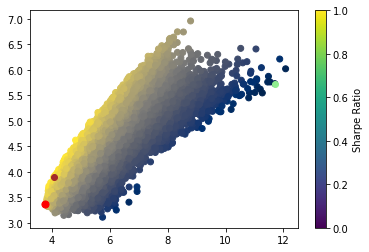

In [98]:
Portofolio(table1,"2019-05-31 00:00:00","Long_Only",2.8,-1.2)

C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: FutureWarning: `item` has been deprecated and will be removed in a future version
C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:95: FutureWarning: `item` has been deprecated and will be removed in a future version
C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: FutureWarning: `item` has been deprecated and will be removed in a future version
C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: FutureWarning: `item` has been deprecated and will be removed in a future version


('2019-05-31 00:00:00',
 7.825600346122241,
 2.4302189695787826,
 1.8313683515704064)

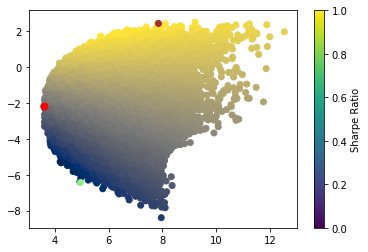

In [276]:
Portofolio(table1,"2019-05-31 00:00:00","Long_Short",2.8,-1.2)

C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: FutureWarning: `item` has been deprecated and will be removed in a future version
C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:95: FutureWarning: `item` has been deprecated and will be removed in a future version
C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: FutureWarning: `item` has been deprecated and will be removed in a future version
C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: FutureWarning: `item` has been deprecated and will be removed in a future version


('2019-05-31 00:00:00',
 5.172460218032497,
 6.888601123758703,
 6.7611447065621295)

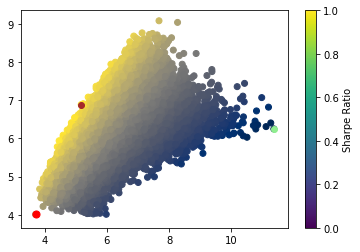

In [100]:
Portofolio(table2,"2019-05-31 00:00:00","Long_Only",2.94,-2.47)

C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: FutureWarning: `item` has been deprecated and will be removed in a future version
C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:95: FutureWarning: `item` has been deprecated and will be removed in a future version
C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: FutureWarning: `item` has been deprecated and will be removed in a future version
C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: FutureWarning: `item` has been deprecated and will be removed in a future version


('2018-09-30 00:00:00',
 6.870200485584801,
 1.5708297182582138,
 5.706011168681993)

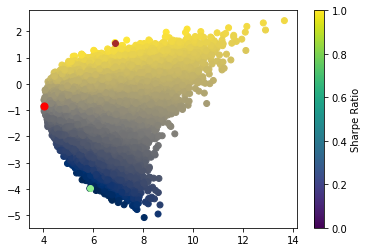

In [277]:
Portofolio(table2,"2018-09-30 00:00:00","Long_Short",2.94,-2.47)

In [552]:
date_list = [] 
Risque_opti_list = [] 
Rdt_opti_list = []
Rendement_backtest_list = []
for i in pd.to_datetime(np.arange(np.datetime64("2013-04-01"), np.datetime64("2019-10-01"), dtype='datetime64[M]'))- datetime.timedelta(days=1):
    date, Risque_opti, Rdt_opti, Rendement_backtest = Portofolio(table1,"{}".format(pd.to_datetime(i)),"Long_Short",3.2,-1.2)
    date_list.append(date)
    Risque_opti_list.append(Risque_opti)
    Rdt_opti_list.append(Rdt_opti)
    Rendement_backtest_list.append(Rendement_backtest)
Long_Short_CB= pd.DataFrame(list(zip(date_list,Risque_opti_list,Rdt_opti_list,Rendement_backtest_list)),columns=["Date","Risque","Rdt_Predit","Rdt_Obs"])
#Long_Short_CB.to_csv("Long_Short_CB.csv",index=False)
Long_Short_CB

C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: FutureWarning: `item` has been deprecated and will be removed in a future version
C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:95: FutureWarning: `item` has been deprecated and will be removed in a future version


,Date,Risque,Rdt_Predit,Rdt_Obs
0,2013-03-31 00:00:00,5.329379,4.595622,0.323644
1,2013-04-30 00:00:00,5.299356,0.559001,-1.302393
2,2013-05-31 00:00:00,9.399671,3.596897,-3.392762
3,2013-06-30 00:00:00,6.618567,3.897853,-0.258877
4,2013-07-31 00:00:00,7.479401,5.401378,2.489649
5,2013-08-31 00:00:00,4.594559,-0.270512,-0.376145
6,2013-09-30 00:00:00,5.382472,1.566504,-3.663877
7,2013-10-31 00:00:00,10.862165,9.688189,-3.997895
8,2013-11-30 00:00:00,3.254234,6.344472,8.846080
9,2013-12-31 00:00:00,6.964202,3.876291,3.322194


In [553]:
date_list = [] 
Risque_opti_list = [] 
Rdt_opti_list = []
Rendement_backtest_list = []
for i in pd.to_datetime(np.arange(np.datetime64("2013-04-01"), np.datetime64("2019-10-01"), dtype='datetime64[M]'))- datetime.timedelta(days=1):
    date, Risque_opti, Rdt_opti, Rendement_backtest = Portofolio(table1,"{}".format(pd.to_datetime(i)),"Long_Only",3.2,-1.2)
    date_list.append(date)
    Risque_opti_list.append(Risque_opti)
    Rdt_opti_list.append(Rdt_opti)
    Rendement_backtest_list.append(Rendement_backtest)
Long_Only_CB= pd.DataFrame(list(zip(date_list,Risque_opti_list,Rdt_opti_list,Rendement_backtest_list)),columns=["Date","Risque","Rdt_Predit","Rdt_Obs"])
#Long_Only_CB.to_csv("Long_Only_CB.csv",index=False)
Long_Only_CB

C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: FutureWarning: `item` has been deprecated and will be removed in a future version
C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:95: FutureWarning: `item` has been deprecated and will be removed in a future version


,Date,Risque,Rdt_Predit,Rdt_Obs
0,2013-03-31 00:00:00,13.681527,10.880229,-3.839845
1,2013-04-30 00:00:00,3.019808,3.166930,4.349489
2,2013-05-31 00:00:00,3.770025,4.068547,4.315407
3,2013-06-30 00:00:00,3.965268,3.397739,4.177905
4,2013-07-31 00:00:00,3.965710,3.583611,-0.488192
5,2013-08-31 00:00:00,2.583563,5.367627,4.357483
6,2013-09-30 00:00:00,4.408661,3.774418,-4.897791
7,2013-10-31 00:00:00,2.980660,4.402827,0.830888
8,2013-11-30 00:00:00,2.928083,5.213681,5.758514
9,2013-12-31 00:00:00,5.442039,4.826192,4.616536


In [ ]:
#Long_Only_CB = Long_Only_CB.fillna(2)

In [554]:
date_list = [] 
Risque_opti_list = [] 
Rdt_opti_list = []
Rendement_backtest_list = []
for i in pd.to_datetime(np.arange(np.datetime64("2013-04-01"), np.datetime64("2019-10-01"), dtype='datetime64[M]'))- datetime.timedelta(days=1):
    date, Risque_opti, Rdt_opti, Rendement_backtest = Portofolio(table2,"{}".format(pd.to_datetime(i)),"Long_Short",3.1,-2.47)
    date_list.append(date)
    Risque_opti_list.append(Risque_opti)
    Rdt_opti_list.append(Rdt_opti)
    Rendement_backtest_list.append(Rendement_backtest)
Long_Short_RF= pd.DataFrame(list(zip(date_list,Risque_opti_list,Rdt_opti_list,Rendement_backtest_list)),columns=["Date","Risque","Rdt_Predit","Rdt_Obs"])
Long_Short_RF

C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: FutureWarning: `item` has been deprecated and will be removed in a future version
C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:95: FutureWarning: `item` has been deprecated and will be removed in a future version


,Date,Risque,Rdt_Predit,Rdt_Obs
0,2013-03-31 00:00:00,4.506090,5.264300,2.211856
1,2013-04-30 00:00:00,3.420126,0.465423,-4.050560
2,2013-05-31 00:00:00,8.022037,0.252364,-8.009634
3,2013-06-30 00:00:00,7.310488,6.490534,2.433938
4,2013-07-31 00:00:00,7.320461,6.723874,3.282619
5,2013-08-31 00:00:00,3.817130,0.861147,0.118640
6,2013-09-30 00:00:00,5.649488,4.949628,-3.283331
7,2013-10-31 00:00:00,9.168583,7.961875,-1.294577
8,2013-11-30 00:00:00,9.816760,0.028921,12.052485
9,2013-12-31 00:00:00,6.956838,4.721169,2.283971


In [555]:
date_list = [] 
Risque_opti_list = [] 
Rdt_opti_list = []
Rendement_backtest_list = []
for i in pd.to_datetime(np.arange(np.datetime64("2013-04-01"), np.datetime64("2019-10-01"), dtype='datetime64[M]'))- datetime.timedelta(days=1):
    date, Risque_opti, Rdt_opti, Rendement_backtest = Portofolio(table2,"{}".format(pd.to_datetime(i)),"Long_Only",3.1,-2.47)
    date_list.append(date)
    Risque_opti_list.append(Risque_opti)
    Rdt_opti_list.append(Rdt_opti)
    Rendement_backtest_list.append(Rendement_backtest)
Long_Only_RF= pd.DataFrame(list(zip(date_list,Risque_opti_list,Rdt_opti_list,Rendement_backtest_list)),columns=["Date","Risque","Rdt_Predit","Rdt_Obs"])
Long_Only_RF

C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: FutureWarning: `item` has been deprecated and will be removed in a future version
C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:95: FutureWarning: `item` has been deprecated and will be removed in a future version


,Date,Risque,Rdt_Predit,Rdt_Obs
0,2013-03-31 00:00:00,2.589627,3.782982,1.960769
1,2013-04-30 00:00:00,2.635714,3.268695,5.324179
2,2013-05-31 00:00:00,3.144181,4.544062,4.196438
3,2013-06-30 00:00:00,3.091376,3.276139,-0.589167
4,2013-07-31 00:00:00,3.097996,3.961697,-1.210877
5,2013-08-31 00:00:00,2.846318,6.050583,3.413886
6,2013-09-30 00:00:00,3.795358,4.014238,-4.767275
7,2013-10-31 00:00:00,3.010519,5.085039,1.628075
8,2013-11-30 00:00:00,2.870143,4.993457,3.733097
9,2013-12-31 00:00:00,9.803187,3.335961,3.520055


In [5]:
Long_Only_RF = pd.read_csv("Long_Only_RF.csv")
Long_Short_RF = pd.read_csv("Long_Short_RF.csv")
Long_Only_CB = pd.read_csv("Long_Only_CB.csv")
Long_Short_CB = pd.read_csv("Long_Short_CB.csv")
LO_RF = 1 + (Long_Only_RF["Rdt_Obs"].fillna(1)/100)
LS_RF = 1 + (Long_Short_RF["Rdt_Obs"]/100)
LO_CB = 1 + (Long_Only_CB["Rdt_Obs"]/100)
LS_CB = 1 + (Long_Short_CB["Rdt_Obs"]/100)
SP5 = pd.read_csv("^GSPC.csv").iloc[39:117,:]
SP5["rdt"]=SP5["Close"]/SP5["Open"]


EONIA = pd.read_csv("C:/Users/louis/Downloads/data.csv",sep=";").dropna().reset_index(drop=True)
EONIA=EONIA.iloc[3:81,2].reset_index(drop=True)
EONIA = EONIA[::-1].reset_index(drop=True)
Eonia4 = 1 + (EONIA.astype(float)/100)
#Eonia4 = np.repeat(1.01222,len(LS_CB)).tolist()

In [6]:
def rdt_cumulé(rdts):
    rdt1 = []
    rdt1.append(rdts[0])
    lance = rdts[0]
    for i in np.arange(1,len(rdts),1):
        lance = lance * rdts[i]
        rdt1.append(lance)
    return lance,rdt1

print(rdt_cumulé(LO_RF)[0])
print(rdt_cumulé(LO_CB)[0])
print(rdt_cumulé(LS_RF)[0])
print(rdt_cumulé(LS_CB)[0])
print(rdt_cumulé(list(SP5["rdt"]))[0])

2.0376932342869845
5.971064774057383
0.7387902817372941
2.5775625113864917
1.7734435157072106


C:\Users\louis\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Réponse stratégie Long Only')

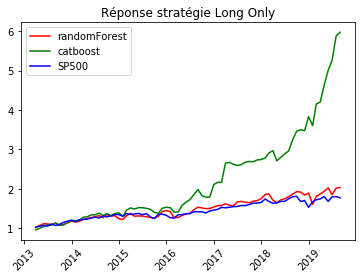

In [7]:
a,b = rdt_cumulé(LO_RF)
c,d = rdt_cumulé(LO_CB)
i,j = rdt_cumulé(list(SP5["rdt"]))
dates = list(Long_Only_RF.loc[0:,"Date"])
tab = pd.DataFrame(list(zip(dates,b,d,j)),columns=["Dates","LO_RF","LO_CB","SP500"])
tab["Dates"] = pd.to_datetime(tab["Dates"])
plt.plot(tab["Dates"],tab["LO_RF"],color="red",label="randomForest") # random forest
plt.plot(tab["Dates"],tab["LO_CB"],color="green",label="catboost")#catboost
plt.plot(tab["Dates"],tab["SP500"],color="blue",label="SP500")
plt.xticks(rotation=45)
plt.legend()
plt.title("Réponse stratégie Long Only")

Text(0.5, 1.0, 'Réponse stratégie Long Short')

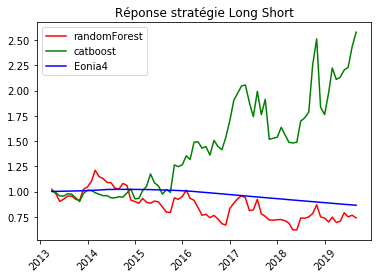

In [8]:
e,f = rdt_cumulé(LS_RF)
g,h = rdt_cumulé(LS_CB)
k,l = rdt_cumulé(Eonia4)
dates = list(Long_Only_RF.loc[0:,"Date"])
tab2 = pd.DataFrame(list(zip(dates,f,h,l)),columns=["Dates","LS_RF","LS_CB","EONIA"])
tab2["Dates"] = pd.to_datetime(tab2["Dates"])
plt.plot(tab2["Dates"],tab2["LS_RF"],color="red",label="randomForest") # random Forest 
plt.plot(tab2["Dates"],tab2["LS_CB"],color="green",label="catboost") #catboost
plt.plot(tab2["Dates"],tab2["EONIA"],color="blue",label="Eonia4")
plt.xticks(rotation=45)
plt.legend()
plt.title("Réponse stratégie Long Short")

Dans les 2 cas de gestion , nous surpassons le Benchmark. Nous dcidons par la suite de conserver nos prédictions liées au catboost. Elles sont particulièrement efficaces.

Nous appliquons par la suite les frais de gestion à ce portefefeuille généré par le catboosting.

#### Fees 1 % 

valeur des fees 1% annualisés : 0.9991628226408794 


Text(0.5, 1.0, 'Réponse stratégie Long Only')

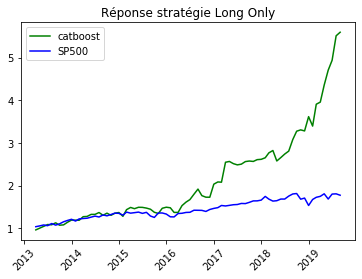

In [9]:
# Fees de 1% annualisé:
valeur_fees_1 = 0.99**(1/12)
print("valeur des fees 1% annualisés : {} ".format(valeur_fees_1))

y,z = rdt_cumulé(LO_CB*valeur_fees_1)
w,x = rdt_cumulé(list(SP5["rdt"]))
dates = list(Long_Only_RF["Date"])
tab = pd.DataFrame(list(zip(dates,z,x)),columns=["Dates","LO_CB","SP500"])
tab["Dates"] = pd.to_datetime(tab["Dates"])
plt.plot(tab["Dates"],tab["LO_CB"],color="green",label="catboost")#catboost
plt.plot(tab["Dates"],tab["SP500"],color="blue",label="SP500")
plt.xticks(rotation=45)
plt.legend()
plt.title("Réponse stratégie Long Only")

Text(0.5, 1.0, 'Réponse stratégie Long Short')

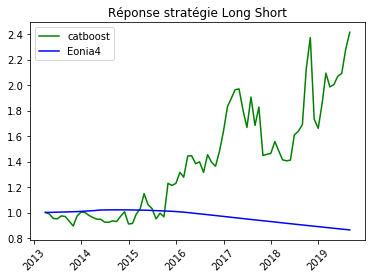

In [10]:
m,n = rdt_cumulé(LS_CB*valeur_fees_1)
g,o = rdt_cumulé(Eonia4)
dates = list(Long_Only_RF["Date"])
tab2 = pd.DataFrame(list(zip(dates,n,o)),columns=["Dates","LS_CB","EONIA"])
tab2["Dates"] = pd.to_datetime(tab2["Dates"])
plt.plot(tab2["Dates"],tab2["LS_CB"],color="green",label="catboost") #catboost
plt.plot(tab2["Dates"],tab2["EONIA"],color="blue",label="Eonia4")
plt.xticks(rotation=45)
plt.legend()
plt.title("Réponse stratégie Long Short")

Nous venons de retrancher les 1% de frais de gestion aux prévisions de notre portefeuille. Nous observons que nous ne travaillons pas sur des données completes. Nous remarquons aussi, que nous surperformons le benchmark en Long only sur la derniere année d'historique et sur les 3 années pour le long short. Nous allons donc retrancher 20 % pour le long Only de 09-2018 à 09-2019 etpour le long short sur toute la période.

#### Fees 20% sur la performance.

In [18]:
# Fees de 20% :
valeur_fees_2 = 0.8##(0.8**(1/12))
print("valeur des fees 20%  : {} ".format(valeur_fees_2))

valeur des fees 20%  : 0.8 


Nous nous concentrons ici seulement sur des performances d'années sans tenir compte des performances précédentes. Il ne faudrait pas en effet, qu'un fond après une année exceptionnelle, se retrouve pénalisé sur une mauvaise année parcequ'il est encore meilleur par ses résultats historiques.

In [12]:
non_cum = pd.DataFrame(list(zip(dates,LO_CB*valeur_fees_1,list(SP5["rdt"]))),columns=["Dates","rdt_LO_CB","Rdt_SP500"])
non_cum["année"]=pd.to_datetime(non_cum["Dates"]).dt.year
liste_année = list(non_cum["année"].unique())
dictionnary = {}
for i in liste_année : 
    temp = non_cum[non_cum["année"]==i]
    if len(temp) == 12 : 
        SP5000_cum = rdt_cumulé(list(temp["Rdt_SP500"]))
        LO_CB_cum = rdt_cumulé(list(temp["rdt_LO_CB"]))
        if LO_CB_cum > SP5000_cum : 
        #test[test["année"]==i]["fees"] = valeur_fees_2
            dictionnary[i] = [valeur_fees_2]
        else : 
            dictionnary[i] = 1
    else : 
        dictionnary[i] = 1
        
rdt_fees2 = []
for i in liste_année:
    temp1 = non_cum[non_cum["année"]==i]["rdt_LO_CB"]
    temp2 = non_cum[non_cum["année"]==i]["Rdt_SP500"]
    temp1 = temp2 + ((temp1-temp2) * dictionnary[i])
    rdt_fees2.extend(temp1)
    
#non_cum["LO_CB_corrigés"] = rdt_fees2

a1,b1 = rdt_cumulé(rdt_fees2)
a2,b2 = rdt_cumulé(list(SP5["rdt"]))
TAB1 = pd.DataFrame(list(zip(non_cum["Dates"],b1,rdt_fees2,b2)),columns=["Dates","Rdt_LO_cum","Rdt_LO","SP500_cum"])

In [13]:
non_cum = pd.DataFrame(list(zip(dates,LS_CB*valeur_fees_1,Eonia4)),columns=["Dates","rdt_LS_CB","Eonia"])
non_cum["année"]=pd.to_datetime(non_cum["Dates"]).dt.year
liste_année = list(non_cum["année"].unique())
dictionnary = {}
for i in liste_année : 
    temp = non_cum[non_cum["année"]==i]
    if len(temp) == 12 : 
        EONIA = rdt_cumulé(list(temp["Eonia"]))
        LS_CB_cum = rdt_cumulé(list(temp["rdt_LS_CB"]))
        if LS_CB_cum > EONIA : 
        #test[test["année"]==i]["fees"] = valeur_fees_2
            dictionnary[i] = [valeur_fees_2]
        else : 
            dictionnary[i] = 1
    else : 
        dictionnary[i] = 1
        
rdt_fees2 = []
for i in liste_année:
    temp1 = non_cum[non_cum["année"]==i]["rdt_LS_CB"]
    temp2 = non_cum[non_cum["année"]==i]["Eonia"]
    temp1 = temp2 + ((temp1-temp2) * dictionnary[i])
    rdt_fees2.extend(temp1)
    
#non_cum["LS_CB_corrigés"] = rdt_fees2

a1,b1 = rdt_cumulé(rdt_fees2)
a2,b2 = rdt_cumulé(Eonia4)
TAB2 = pd.DataFrame(list(zip(non_cum["Dates"],b1,rdt_fees2,b2)),columns=["Dates","Rdt_LS_cum","Rdt_LS","Eonia_cum"])

In [14]:
Rdt_Finaux = pd.merge(TAB1,TAB2, on="Dates")
Rdt_Finaux["Dates"]=pd.to_datetime(Rdt_Finaux["Dates"])
Rdt_Finaux["Rdt_LO"] = (Rdt_Finaux["Rdt_LO"]-1)*100
Rdt_Finaux["Rdt_LS"] = (Rdt_Finaux["Rdt_LS"]-1)*100
Rdt_Finaux

,Dates,Rdt_LO_cum,Rdt_LO,SP500_cum,Rdt_LS_cum,Rdt_LS,Eonia_cum
0,2013-03-31,0.960797,-3.920348,1.035988,1.002397,0.239655,1.000670
1,2013-04-30,1.001747,4.262130,1.054731,0.988513,-1.385021,1.001481
2,2013-05-31,1.044102,4.228076,1.076644,0.954176,-3.473640,1.002272
3,2013-06-30,1.086812,4.090690,1.059864,0.950909,-0.342378,1.003134
4,2013-07-31,1.080601,-0.571501,1.109869,0.973767,2.403847,1.004067
...,...,...,...,...,...,...,...
73,2019-04-30,3.727131,10.080557,1.806769,1.752555,0.898638,0.876824
74,2019-05-31,4.026801,8.040237,1.684208,1.810541,3.308621,0.873606
75,2019-06-30,4.224601,4.912096,1.800647,1.829724,1.059537,0.870444
76,2019-07-31,4.715912,11.629745,1.806083,1.996157,9.096064,0.867249


Text(0.5, 1.0, 'Performance finale avec retranchement de Fees')

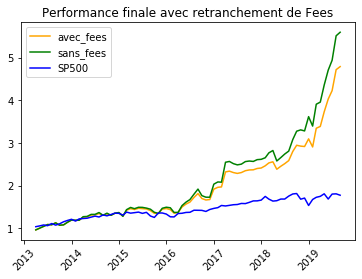

In [15]:
plt.plot(Rdt_Finaux["Dates"],Rdt_Finaux["Rdt_LO_cum"],color="orange",label="avec_fees") # random forest
plt.plot(tab["Dates"],tab["LO_CB"],color="green",label="sans_fees")#catboost
plt.plot(Rdt_Finaux["Dates"],Rdt_Finaux["SP500_cum"],color="blue",label="SP500")
plt.xticks(rotation=45)
#plt.ylim(3.5,4)
plt.legend()
plt.title("Performance finale avec retranchement de Fees")

Text(0.5, 1.0, 'Performance finale avec retranchement de Fees')

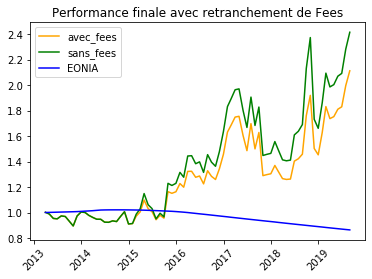

In [16]:
plt.plot(Rdt_Finaux["Dates"],Rdt_Finaux["Rdt_LS_cum"],color="orange",label="avec_fees") # random Forest 
plt.plot(tab2["Dates"],tab2["LS_CB"],color="green",label="sans_fees") #catboost
plt.plot(Rdt_Finaux["Dates"],Rdt_Finaux["Eonia_cum"],color="blue",label="EONIA")
plt.xticks(rotation=45)
plt.legend()
plt.title("Performance finale avec retranchement de Fees")

In [17]:
Rdt_Finaux

,Dates,Rdt_LO_cum,Rdt_LO,SP500_cum,Rdt_LS_cum,Rdt_LS,Eonia_cum
0,2013-03-31,0.960797,-3.920348,1.035988,1.002397,0.239655,1.000670
1,2013-04-30,1.001747,4.262130,1.054731,0.988513,-1.385021,1.001481
2,2013-05-31,1.044102,4.228076,1.076644,0.954176,-3.473640,1.002272
3,2013-06-30,1.086812,4.090690,1.059864,0.950909,-0.342378,1.003134
4,2013-07-31,1.080601,-0.571501,1.109869,0.973767,2.403847,1.004067
...,...,...,...,...,...,...,...
73,2019-04-30,3.727131,10.080557,1.806769,1.752555,0.898638,0.876824
74,2019-05-31,4.026801,8.040237,1.684208,1.810541,3.308621,0.873606
75,2019-06-30,4.224601,4.912096,1.800647,1.829724,1.059537,0.870444
76,2019-07-31,4.715912,11.629745,1.806083,1.996157,9.096064,0.867249


In [157]:
Rdt_Finaux.to_csv("Rdt_Finaux.csv",index=False)

In [158]:
# Apport des rendements corrigés des fees pour les prochaines question : 
Perf_LO_CB = pd.read_csv("Long_Only_CB.csv").loc[0:76,:]
Perf_LS_CB = pd.read_csv("Long_Short_CB.csv").loc[0:76,:]
Perf_LO_CB["Rdt_Obs"] = Rdt_Finaux["Rdt_LO"]
Perf_LS_CB["Rdt_Obs"] = Rdt_Finaux["Rdt_LS"]
Perf_LO_CB.to_csv("Perf_LO_CB.csv",index=False)
Perf_LS_CB.to_csv("Perf_LS_CB.csv",index=False)